In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Define the values
M_constrained = np.array([[1000]])  # Mass (kg)
K_constrained = np.array([[1e5]])  # Spring constant (N/m)
f_constrained = np.array([[9810]])  # Force (N)


dt = 0.005               # Time step = T/200
total_time = 10          # Total simulation time

# Calculate number of steps
n_steps = int(total_time / dt)+1

magnitudes = ((1.0, 2.0, 3.0),)

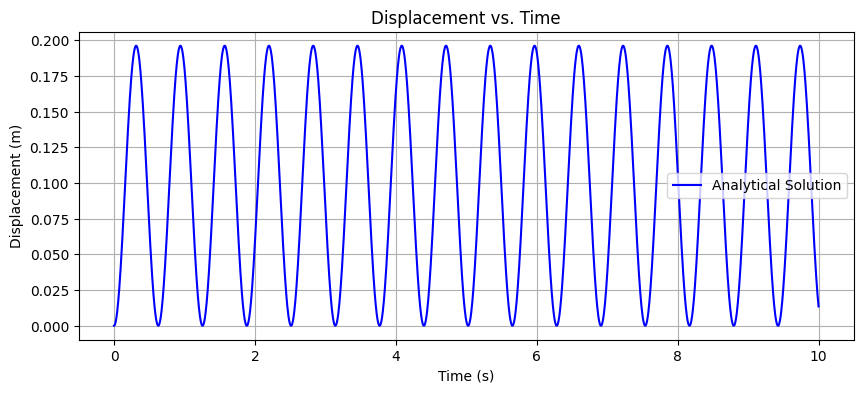

Maximum displacement: 0.19619812245041593
Maximum velocity: 0.9809976144851804
Maximum acceleration: 9.81


In [11]:
t = np.linspace(0, total_time, n_steps)  # Time array
# Analytical solution for displacement
omega = np.sqrt(K_constrained / M_constrained).item()  # Natural frequency (scalar)
x_analtical = (f_constrained.item() / K_constrained.item()) * (1 - np.cos(omega * t))  # Displacement

# Calculate velocity and acceleration
v_analytical = (f_constrained.item() / K_constrained.item()) * omega * np.sin(omega * t)
a_analytical = (f_constrained.item() / K_constrained.item()) * omega**2 * np.cos(omega * t)


plt.figure(figsize=(10, 4))
plt.plot(t, x_analtical, 'b-', linewidth=1.5, label='Analytical Solution')
plt.xlabel('Time (s)')
plt.ylabel('Displacement (m)')
plt.title('Displacement vs. Time')
plt.grid(True)
plt.legend()
plt.show()


print(f"Maximum displacement: {max(x_analtical)}")
print(f"Maximum velocity: {max(v_analytical.flatten())}")
print(f"Maximum acceleration: {max(a_analytical.flatten())}")

In [12]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from pathlib import Path
from tabulate import tabulate

# Get system dimensions
n_dof = M_constrained.shape[0]  # Number of degrees of freedom
n_cases = f_constrained.shape[0]  # Number of load cases

# Define x using the same values as x_analtical
x0 = np.zeros((n_dof, n_cases)) # Displacement (m) as a 1x1 matrix

s = f_constrained.shape[0]
# Initialize initial velocity as zero vector
v0 = np.zeros((n_dof, n_cases))  # Initial velocities (n×m)

y0 = np.vstack([x0, v0]).flatten()  # Stack initial conditions into a column vector|

# Time span
t_span = (0, total_time)  # From t=0 to t=1
t_eval = np.linspace(0, total_time, n_steps)  # Time points where the solution is evaluated

def dUdt(t, y):
    y = y.reshape(-1, 1)
    x, v = y[0], y[1]  # Extract displacement and velocity
    dxdt = v
    dvdt = (f_constrained - K_constrained @ x) / M_constrained  # Matrix multiplication
    return np.vstack([dxdt, dvdt]).flatten()  # Stack results into a column vector

# Get number of cases and magnitudes
num_cases = f_constrained.shape[1]

# Create the base directory
base_dir = Path("Dynamic_solution")
base_dir.mkdir(exist_ok=True)

# Print initial information
print("Starting multi-case dynamic analysis...")
print(f"Function called with:\nM: {M_constrained.shape}, K: {K_constrained.shape}, f: {f_constrained.shape}, magnitudes: {magnitudes}, x: {x0.shape}\n")
print(f"Number of cases: {num_cases}")

# Results storage
results = []
case_times = []

# Solve the system for each case
start_time = time.time()
for case in tqdm(range(num_cases), desc="Solving cases"):
    case_start_time = time.time()
    print(f"\nSolving case {case + 1}/{num_cases}")
    magnitude = magnitudes[case]
    print(f"Magnitude: {magnitude}")
    
    # Create case folder name
    magnitude_str = ", ".join(str(val) for val in magnitude)
    case_folder = base_dir / f"case_{case+1}_magnitude_({magnitude_str})"
    analytical_folder = case_folder / "Analytical_Solution"
    analytical_folder.mkdir(parents=True, exist_ok=True)
    
    # Initial state vector for this case
    sol = solve_ivp(dUdt, t_span, y0, t_eval=t_eval, method='LSODA', atol=1e-10, rtol=1e-10)
    
    # Extract results
    t = sol.t
    U = sol.y
    u = U[:s]  # Velocity
    v = U[s:]  # Displacement
    a = (f_constrained.item() - K_constrained.item() * u) / M_constrained.item()  # Acceleration
    
    # Save results
    np.save(analytical_folder / 'time.npy', t)
    np.save(analytical_folder / 'displacement.npy', u)
    np.save(analytical_folder / 'velocity.npy', v)
    np.save(analytical_folder / 'acceleration.npy', a)
    
    # Store summary results
    case_time = time.time() - case_start_time
    case_times.append(case_time)
    
    results.append({
        "case": case + 1,
        "magnitude": magnitude,
        "max_displacement": np.max(np.abs(u)),
        "max_velocity": np.max(np.abs(v)),
        "max_acceleration": np.max(np.abs(a)),
        "solve_time": case_time
    })
    
    print(f"Case {case + 1} completed in {case_time:.2f} seconds.")
    print(f"Results saved to {analytical_folder}")

# Print results summary
print("\nResults Summary:")
print("=" * 80)
summary_data = [[r["case"], 
                str(r["magnitude"]), 
                f"{r['max_displacement']:.2e}",
                f"{r['max_velocity']:.2e}", 
                f"{r['max_acceleration']:.2e}",
                f"{r['solve_time']:.2f}"] for r in results]

headers = ["Case", "Magnitude", "Max Displacement", "Max Velocity", "Max Acceleration", "Solve Time (s)"]
print(tabulate(summary_data, headers=headers, tablefmt="grid"))

# Print overall statistics
total_time = sum(case_times)
print("\nOverall Statistics:")
print("=" * 80)
print(f"Total computation time: {total_time:.2f} seconds")
print(f"Average time per case: {total_time/num_cases:.2f} seconds")
print(f"Number of cases: {num_cases}")
print(f"Fastest case: {min(case_times):.2f} seconds (Case {np.argmin(case_times)+1})")
print(f"Slowest case: {max(case_times):.2f} seconds (Case {np.argmax(case_times)+1})")

print(f"\nAnalysis complete. Results saved in: {base_dir.resolve()}")

Starting multi-case dynamic analysis...
Function called with:
M: (1, 1), K: (1, 1), f: (1, 1), magnitudes: ((1.0, 2.0, 3.0),), x: (1, 1)

Number of cases: 1


Solving cases:   0%|          | 0/1 [00:00<?, ?it/s]


Solving case 1/1
Magnitude: (1.0, 2.0, 3.0)


Solving cases: 100%|██████████| 1/1 [00:00<00:00,  6.52it/s]

Case 1 completed in 0.15 seconds.
Results saved to Dynamic_solution\case_1_magnitude_(1.0, 2.0, 3.0)\Analytical_Solution

Results Summary:
+--------+-----------------+--------------------+----------------+--------------------+------------------+
|   Case | Magnitude       |   Max Displacement |   Max Velocity |   Max Acceleration |   Solve Time (s) |
+========+=================+====================+================+====================+==================+
|      1 | (1.0, 2.0, 3.0) |              0.196 |          0.981 |               9.81 |             0.15 |
+--------+-----------------+--------------------+----------------+--------------------+------------------+

Overall Statistics:
Total computation time: 0.15 seconds
Average time per case: 0.15 seconds
Number of cases: 1
Fastest case: 0.15 seconds (Case 1)
Slowest case: 0.15 seconds (Case 1)

Analysis complete. Results saved in: D:\Git_clone\Thesis_Cleaned\2D_beam_udl_loading\Dynamic_solution


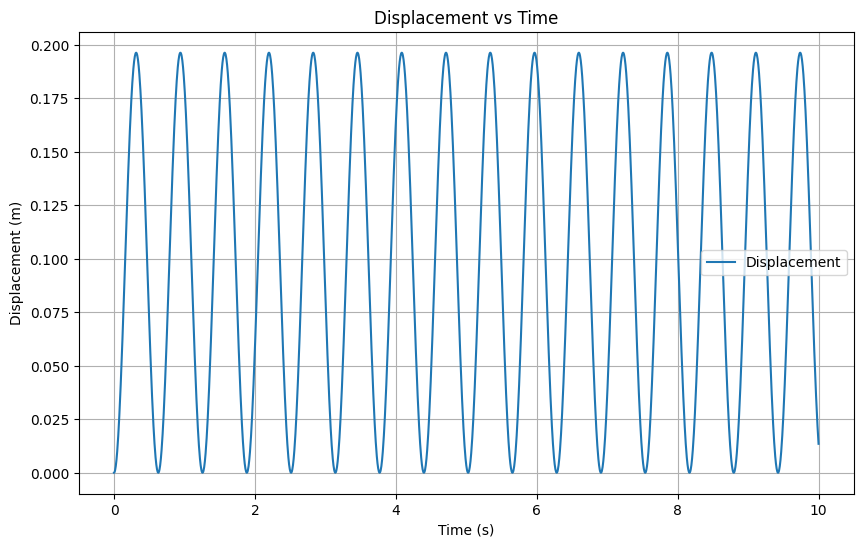

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(t, u[0], label='Displacement')
plt.xlabel('Time (s)')
plt.ylabel('Displacement (m)')
plt.title('Displacement vs Time')
plt.grid(True)
plt.legend()
plt.show()

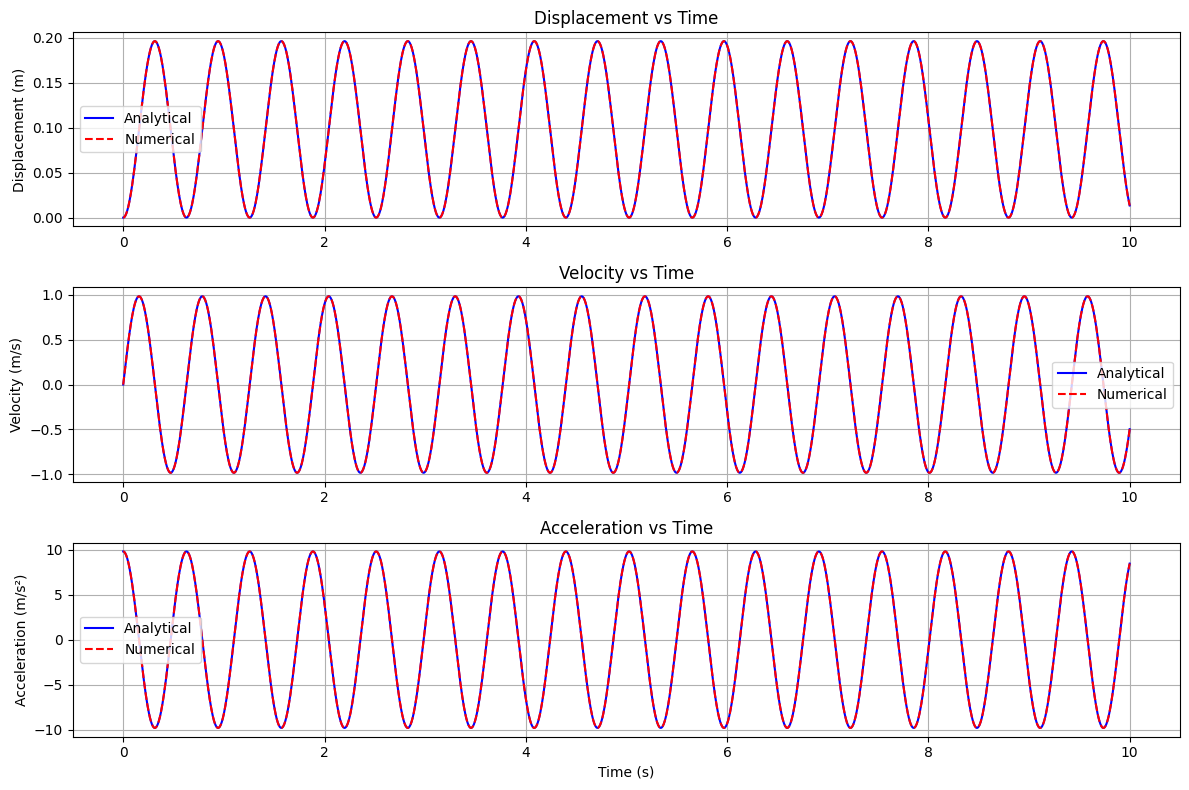

In [14]:
# Create figure with 3 subplots
plt.figure(figsize=(12, 8))

# Displacement plot
plt.subplot(3, 1, 1)
plt.plot(t_eval, x_analtical, 'b-', label='Analytical')
plt.plot(t_eval, u[0], 'r--', label='Numerical')
plt.ylabel('Displacement (m)')
plt.title('Displacement vs Time')
plt.grid(True)
plt.legend()

# Velocity plot
plt.subplot(3, 1, 2)
plt.plot(t_eval, v_analytical, 'b-', label='Analytical')
plt.plot(t_eval, v[0], 'r--', label='Numerical')
plt.ylabel('Velocity (m/s)')
plt.title('Velocity vs Time')
plt.grid(True)
plt.legend()

# Acceleration plot
plt.subplot(3, 1, 3)
plt.plot(t_eval, a_analytical, 'b-', label='Analytical')
plt.plot(t_eval, a[0], 'r--', label='Numerical')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s²)')
plt.title('Acceleration vs Time')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [15]:
import numpy as np
from scipy import linalg
import os
import shutil
from pathlib import Path
from tqdm import tqdm
import time
from tabulate import tabulate

def solve_newmark_dynamic_single_case(structural_components, initial_displacement, total_time, dt, 
                                     beta, gamma, tol, max_iter):
    """
    Solve dynamic system for a single case using Newmark-β method

    Args:
        structural_components (dict): Contains system matrices (M, K, F)
        initial_displacement (np.array): Initial displacement vector for this case (1D array)
        total_time (float): Total simulation time
        dt (float): Time step size
        beta (float): Newmark-β parameter
        gamma (float): Newmark-γ parameter
        tol (float): Convergence tolerance
        max_iter (int): Maximum iterations per time step

    Returns:
        dict: Results including displacements, velocities, accelerations, etc.
    """
    # Get system matrices and force vector
    M = structural_components['M_constrained']
    K = structural_components['K_constrained']
    F = structural_components['f_constrained']
    n = M.shape[0]

    # Scale matrices to improve conditioning
    M_scale = 1.0 
    K_scale = 1.0 
    F_scale = 1.0 

    M_scaled = M / M_scale
    K_scaled = K / K_scale
    F_scaled = F / F_scale
    
    print("\nMatrix scaling factors:")
    print(f"Mass matrix scale: {M_scale:.2e}")
    print(f"Stiffness matrix scale: {K_scale:.2e}")
    print(f"Force vector scale: {F_scale:.2e}")

    # Setup time integration
    n_steps = int(total_time / dt) + 1
    t = np.linspace(0, total_time, n_steps)

    # Initialize solution arrays
    d = np.zeros((n_steps, n))  # Displacement
    v = np.zeros((n_steps, n))  # Velocity
    a = np.zeros((n_steps, n))  # Acceleration

    # Set initial displacement for this case
    d[0] = initial_displacement  # Correctly set the initial displacement

    # Initial acceleration
    # a[0] = linalg.solve(M_scaled, F_scaled[0] - K_scaled @ d[0])
    a[0] = (F_scaled - K_scaled @ d[0]) / M_scaled  # Correct initial acceleration

    # Newmark constants (pre-calculate for efficiency)
    c1 = 1 / (beta * dt**2)
    c2 = gamma / (beta * dt)
    c3 = 1 / (beta * dt)
    c5 = (1 - 2 * beta) / (2 * beta)

    # Effective stiffness matrix (K_tan^dyn), pre-factor for efficiency
    K_eff = K_scaled + c1 * M_scaled
    K_eff_factor = linalg.lu_factor(K_eff)

    # Convergence tracking arrays
    iterations_per_step = np.zeros(n_steps, dtype=int)
    residuals_per_step = np.zeros(n_steps)
    convergence_status = np.ones(n_steps, dtype=bool)

    # Time stepping
    for i in range(1, n_steps):
        # a_pred = a[i-1].copy()  # Initial guess for a_i
        # d_pred = d[i - 1] + dt * v[i - 1] + (dt**2) * ((1 - 2 * beta) / 2 * a[i - 1] + beta * a_pred)
        # v_pred = v[i - 1] + dt * ((1 - gamma) * a[i - 1] + gamma * a_pred)
        d_pred = d[i-1] + dt*v[i-1] + (0.5-beta)*dt**2*a[i-1]
        v_pred = v[i-1] + (1-gamma)*dt*a[i-1]

        # Newton-Raphson iteration
        d[i] = d_pred.copy()  # Initial guess for displacement at i
        v[i] = v_pred.copy()  # Initial guess for velocity at i
        converged = False

        for j in range(max_iter):
            # Calculate accelerations and velocities based on x_{n+1} (Eqs. 2.17 & 2.18)
            a_i = c1 * (d[i] - d[i - 1]) - c3 * v[i - 1] - c5 * a[i - 1]
            v_i = c2 * (d[i] - d[i - 1]) - (gamma/beta - 1) * v[i-1] - (dt/2) * (gamma/beta - 2) * a[i - 1]

            # Calculate the residual force (Eq 2.19):
            R = F - M @ a_i - K @ d[i]

            residual_norm = np.linalg.norm(R)

            # Check for Convergence
            if residual_norm < tol:
                converged = True
                iterations_per_step[i] = j + 1
                residuals_per_step[i] = residual_norm
                a[i] = a_i
                v[i] = v_i
                break

            # Solve for the displacement increment (delta_d)
            try:
                delta_d = linalg.lu_solve(K_eff_factor, R)
                d[i] += delta_d
                a[i] = a_i
                v[i] = v_i
            except np.linalg.LinAlgError:
                break
        

        if not converged:
            convergence_status[i] = False
            iterations_per_step[i] = max_iter
            residuals_per_step[i] = residual_norm
            a[i] = a_i
            v[i] = v_i
    
    return {
        'time': t,
        'displacement': d,
        'velocity': v,
        'acceleration': a,
        'iterations_per_step': iterations_per_step,
        'residuals_per_step': residuals_per_step,
        'convergence_status': convergence_status,
        'scales': {'M_scale': M_scale, 'K_scale': K_scale, 'F_scale': F_scale}
    }



def analyze_and_print_results(case_results, case_times, magnitudes):
    """
    Analyze results from all cases and print detailed tabulated information
    """
    n_cases = len(case_results)
    
    # Prepare data for summary table
    summary_data = []
    convergence_data = []
    performance_data = []
    
    for idx, (results, solve_time, magnitude) in enumerate(zip(case_results, case_times, magnitudes)):
        iterations = results['iterations_per_step']
        residuals = results['residuals_per_step']
        conv_status = results['convergence_status']
        n_steps = len(results['time'])
        
        # Summary statistics
        converged_steps = np.sum(conv_status)
        non_converged = n_steps - converged_steps
        max_disp = np.max(np.abs(results['displacement']))
        max_vel = np.max(np.abs(results['velocity']))
        max_acc = np.max(np.abs(results['acceleration']))
        
        # Iteration statistics
        converged_iters = iterations[conv_status]
        avg_iters = np.mean(converged_iters) if len(converged_iters) > 0 else 0
        max_iters = np.max(iterations)
        min_iters = np.min(converged_iters) if len(converged_iters) > 0 else 0
        
        # Add to summary table
        summary_data.append([
            idx + 1,
            str(magnitude),
            f"{max_disp:.2e}",
            f"{max_vel:.2e}",
            f"{max_acc:.2e}",
            f"{solve_time:.2f}"
        ])
        
        # Add to convergence table
        convergence_data.append([
            idx + 1,
            str(magnitude),
            converged_steps,
            non_converged,
            f"{(converged_steps/n_steps)*100:.1f}%",
            f"{min_iters:.1f}",
            f"{avg_iters:.1f}",
            max_iters
        ])
        
        # Collect iteration distribution
        iter_dist = {}
        for i in range(1, max_iters + 1):
            count = np.sum(iterations == i)
            if count > 0:
                iter_dist[i] = count
        
        # Add to performance table
        performance_data.append([
            idx + 1,
            str(magnitude),
            f"{np.min(residuals):.2e}",
            f"{np.mean(residuals):.2e}",
            f"{np.max(residuals):.2e}",
            f"{solve_time/n_steps:.4f}",
            str(iter_dist)
        ])
    
    # Print Summary Table
    print("\nResults Summary:")
    print("=" * 80)
    headers = ["Case", "Magnitude", "Max Displacement", "Max Velocity", "Max Acceleration", "Solve Time (s)"]
    print(tabulate(summary_data, headers=headers, tablefmt="grid"))
    
    # Print Convergence Table
    print("\nConvergence Analysis:")
    print("=" * 80)
    headers = ["Case", "Magnitude", "Converged Steps", "Non-converged", "Success Rate", 
              "Min Iters", "Avg Iters", "Max Iters"]
    print(tabulate(convergence_data, headers=headers, tablefmt="grid"))
    
    # Print Performance Table
    print("\nPerformance Analysis:")
    print("=" * 80)
    headers = ["Case", "Magnitude", "Min Residual", "Avg Residual", "Max Residual", 
              "Time per Step (s)", "Iteration Distribution"]
    print(tabulate(performance_data, headers=headers, tablefmt="grid"))
    
    # Print Overall Statistics
    print("\nOverall Statistics:")
    print("=" * 80)
    total_time = np.sum(case_times)
    print(f"Total computation time: {total_time:.2f} seconds")
    print(f"Average time per case: {total_time/n_cases:.2f} seconds")
    print(f"Number of cases: {n_cases}")
    print(f"Fastest case: {np.min(case_times):.2f} seconds (Case {np.argmin(case_times)+1})")
    print(f"Slowest case: {np.max(case_times):.2f} seconds (Case {np.argmax(case_times)+1})")

def save_case_results(results, case_dir):
    """
    Save results for a single case with comprehensive solution storage
    """
    # Create solution directory
    solution_dir = case_dir / 'solution'
    solution_dir.mkdir(exist_ok=True)
    
    # Save raw solution arrays as .npy files
    np.save(solution_dir / 'time.npy', results['time'])
    np.save(solution_dir / 'displacement.npy', results['displacement'])
    np.save(solution_dir / 'velocity.npy', results['velocity'])
    np.save(solution_dir / 'acceleration.npy', results['acceleration'])
    
    # Save time history data in compressed format
    np.savez(case_dir / 'time_history.npz',
             time=results['time'],
             displacement=results['displacement'],
             velocity=results['velocity'],
             acceleration=results['acceleration'])
    
    # Save convergence data
    np.savez(case_dir / 'convergence_data.npz',
             iterations=results['iterations_per_step'],
             residuals=results['residuals_per_step'],
             convergence_status=results['convergence_status'])
    
    # Save scaling factors
    np.savez(case_dir / 'scaling_factors.npz', **results['scales'])
    
    # Save summary statistics
    with open(case_dir / 'summary.txt', 'w') as f:
        f.write("Results Summary:\n")
        f.write("=" * 50 + "\n")
        f.write(f"Time steps completed: {len(results['time'])}\n")
        f.write(f"Maximum displacement: {np.max(np.abs(results['displacement'])):.2e}\n")
        f.write(f"Maximum velocity: {np.max(np.abs(results['velocity'])):.2e}\n")
        f.write(f"Maximum acceleration: {np.max(np.abs(results['acceleration'])):.2e}\n")
        f.write(f"Converged steps: {np.sum(results['convergence_status'])}\n")
        f.write(f"Non-converged steps: {np.sum(~results['convergence_status'])}\n")
        f.write("\nFile Locations:\n")
        f.write("-" * 30 + "\n")
        f.write(f"Solution arrays (.npy files): {solution_dir}\n")
        f.write(f"Time history: {case_dir/'time_history.npz'}\n")
        f.write(f"Convergence data: {case_dir/'convergence_data.npz'}\n")
        f.write(f"Scaling factors: {case_dir/'scaling_factors.npz'}\n")


def solve_newmark_dynamic_multi_case(M, K, f, magnitudes, x, total_time=1.0, dt=0.01, beta=0.25, gamma=0.5, tol=1e-6, max_iter=50):
    print("Function called with:")
    print(f"M: {M.shape}, K: {K.shape}, f: {f.shape}, magnitudes: {magnitudes}, x: {x.shape}")
    # Rest of the function implementation
    """
    Solve dynamic system for multiple cases using Newmark-β method

    Args:
        M (np.array): Mass matrix
        K (np.array): Stiffness matrix
        f (np.array): Force matrix (each column corresponds to a case)
        magnitudes (list): List of magnitudes for each case
        x (np.array): Initial displacement matrix (each column corresponds to a case)
        total_time (float): Total simulation time
        dt (float): Time step size
        beta (float): Newmark-β parameter
        gamma (float): Newmark-γ parameter
        tol (float): Convergence tolerance
        max_iter (int): Maximum iterations per time step

    Returns:
        output_dir (Path): Directory where results are saved
        case_results (list): List of results for each case
        case_times (list): List of computation times for each case
    """
    output_dir = Path("Dynamic_solution")
    if output_dir.exists():
        shutil.rmtree(output_dir)
    output_dir.mkdir()
    
    n_dof = M.shape[0]
    n_cases = f.shape[1]
    
    print(f"\nStarting multi-case dynamic analysis...")
    print(f"Number of DOFs: {n_dof}")
    print(f"Number of cases: {n_cases}")
    
    # Track results and timing for each case
    case_results = []
    case_times = []
    
    for case_idx in tqdm(range(n_cases), desc="Processing cases"):
        case_dir = output_dir / f"case_{case_idx+1}_magnitude_{magnitudes[case_idx]}" / "Numerical_Solution"
        case_dir.mkdir(parents=True, exist_ok=True)
        
        structural_components = {
            'M_constrained': M,
            'K_constrained': K,
            'f_constrained': f[:, case_idx]
        }
        
        print(f"\nSolving case {case_idx+1}/{n_cases}")
        print(f"Magnitude: {magnitudes[case_idx]}")
        
        try:
            # Time the solution
            start_time = time.time()
            results = solve_newmark_dynamic_single_case(
                structural_components,
                initial_displacement=x[:, case_idx],  # Pass initial displacement for this case
                total_time=total_time,
                dt=dt,
                beta=beta,
                gamma=gamma,
                tol=tol,
                max_iter=max_iter
            )
            solve_time = time.time() - start_time
            
            # Store results and timing
            case_results.append(results)
            case_times.append(solve_time)
            
            # Save results
            save_case_results(results, case_dir)
            
        except Exception as e:
            print(f"Error in case {case_idx+1}: {str(e)}")
            continue
    
    # Analyze and print detailed results
    analyze_and_print_results(case_results, case_times, magnitudes)
    
    return output_dir, case_results, case_times

if __name__ == "__main__":
    try:
        print("Starting multi-case dynamic analysis...")
        
        output_dir, case_results, case_times = solve_newmark_dynamic_multi_case(
            M=M_constrained,
            K=K_constrained,
            f=f_constrained,
            magnitudes=magnitudes,
            x=x0,  
            total_time=0.01, #0.01,
            dt= 3.14e-6, #3.14e-6, #0.05, # 
            beta=0.25,
            gamma=0.5,
            tol=1e-8,
            max_iter=50
        )
        
        print(f"\nAnalysis complete. Results saved in: {output_dir}")
        
    except Exception as e:
        print(f"Error in dynamic analysis: {str(e)}")
        import traceback
        traceback.print_exc()

Starting multi-case dynamic analysis...
Function called with:
M: (1, 1), K: (1, 1), f: (1, 1), magnitudes: ((1.0, 2.0, 3.0),), x: (1, 1)

Starting multi-case dynamic analysis...
Number of DOFs: 1
Number of cases: 1


Processing cases:   0%|          | 0/1 [00:00<?, ?it/s]


Solving case 1/1
Magnitude: (1.0, 2.0, 3.0)

Matrix scaling factors:
Mass matrix scale: 1.00e+00
Stiffness matrix scale: 1.00e+00
Force vector scale: 1.00e+00


Processing cases: 100%|██████████| 1/1 [00:11<00:00, 11.37s/it]


Results Summary:
+--------+-----------------+--------------------+----------------+--------------------+------------------+
|   Case | Magnitude       |   Max Displacement |   Max Velocity |   Max Acceleration |   Solve Time (s) |
+========+=================+====================+================+====================+==================+
|      1 | (1.0, 2.0, 3.0) |            0.00049 |         0.0979 |               9.81 |            11.34 |
+--------+-----------------+--------------------+----------------+--------------------+------------------+

Convergence Analysis:
+--------+-----------------+-------------------+-----------------+----------------+-------------+-------------+-------------+
|   Case | Magnitude       |   Converged Steps |   Non-converged | Success Rate   |   Min Iters |   Avg Iters |   Max Iters |
+========+=================+===================+=================+================+=============+=============+=============+
|      1 | (1.0, 2.0, 3.0) |               172

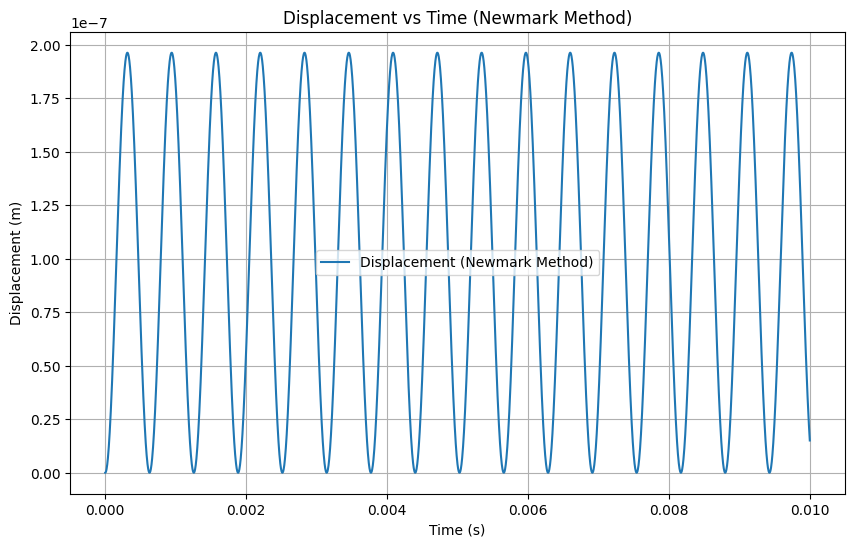

In [14]:
import matplotlib.pyplot as plt

# Extract time and displacement from the solution
time = case_results[0]['time']
displacement = case_results[0]['displacement']

# Plot displacement vs time
plt.figure(figsize=(10, 6))
plt.plot(time, displacement, label='Displacement (Newmark Method)')
plt.xlabel('Time (s)')
plt.ylabel('Displacement (m)')
plt.title('Displacement vs Time (Newmark Method)')
plt.grid(True)
plt.legend()
plt.show()

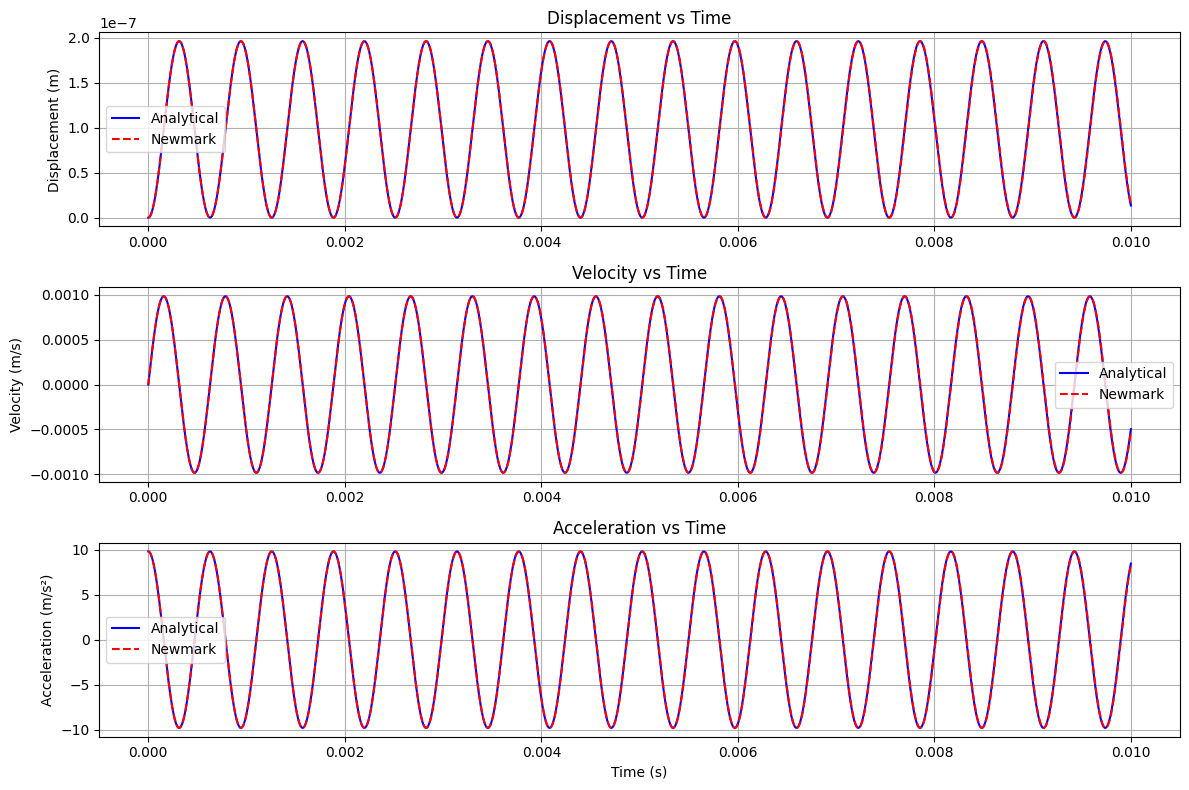

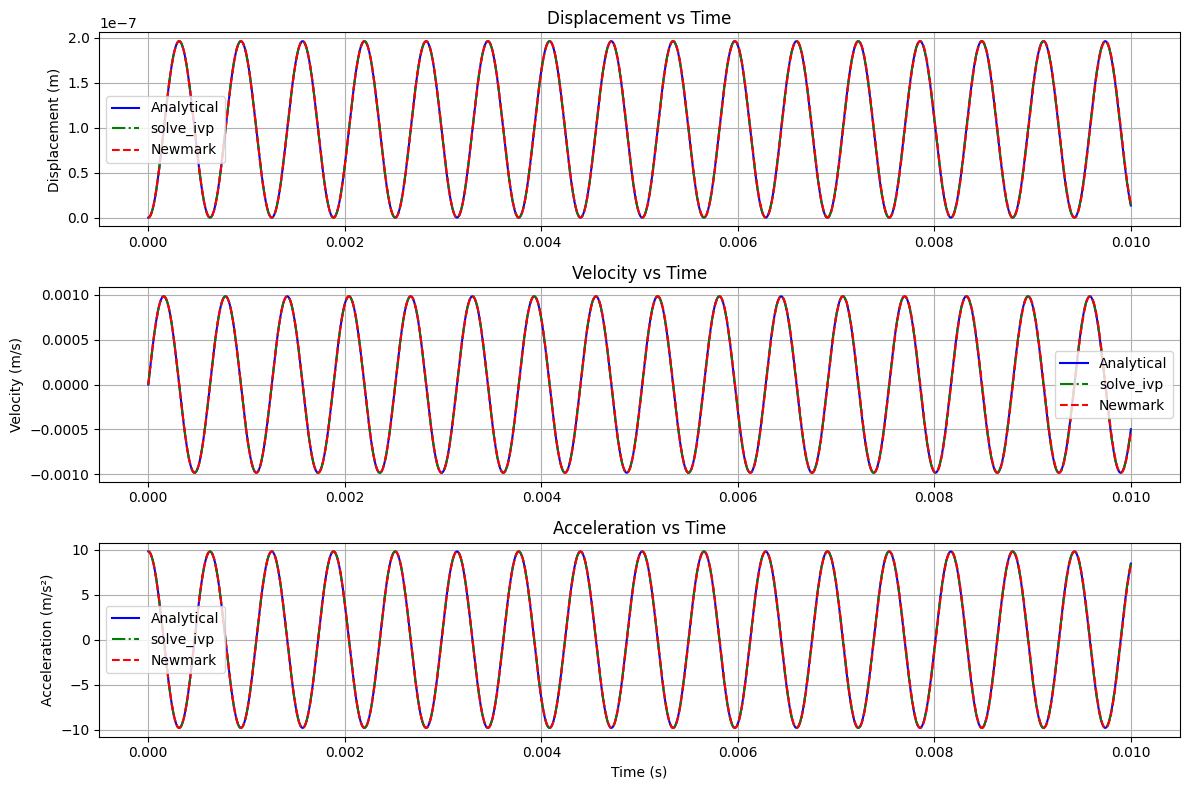

In [15]:
# First ensure all arrays have matching lengths
min_length = min(len(t_eval), 
                 len(case_results[0]['displacement']),
                 len(u[0]),
                 len(v[0]),
                 len(a[0]))

# Slice all arrays to this common length
t_common = t_eval[:min_length]
x_analytical_common = x_analtical[:min_length]
v_analytical_common = v_analytical[:min_length]
a_analytical_common = a_analytical[:min_length]

# Chart 1: Comparison between analytical solution and Newmark solution
plt.figure(figsize=(12, 8))

# Displacement plot
plt.subplot(3, 1, 1)
plt.plot(t_common, x_analytical_common, 'b-', label='Analytical')
plt.plot(t_common, case_results[0]['displacement'][:min_length].flatten(), 'r--', label='Newmark')
plt.ylabel('Displacement (m)')
plt.title('Displacement vs Time')
plt.grid(True)
plt.legend()

# Velocity plot
plt.subplot(3, 1, 2)
plt.plot(t_common, v_analytical_common, 'b-', label='Analytical')
plt.plot(t_common, case_results[0]['velocity'][:min_length].flatten(), 'r--', label='Newmark')
plt.ylabel('Velocity (m/s)')
plt.title('Velocity vs Time')
plt.grid(True)
plt.legend()

# Acceleration plot
plt.subplot(3, 1, 3)
plt.plot(t_common, a_analytical_common, 'b-', label='Analytical')
plt.plot(t_common, case_results[0]['acceleration'][:min_length].flatten(), 'r--', label='Newmark')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s²)')
plt.title('Acceleration vs Time')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Chart 2: Comparison of all three solutions
plt.figure(figsize=(12, 8))

# Displacement plot
plt.subplot(3, 1, 1)
plt.plot(t_common, x_analytical_common, 'b-', label='Analytical')
plt.plot(t_common, u[0][:min_length], 'g-.', label='solve_ivp')
plt.plot(t_common, case_results[0]['displacement'][:min_length].flatten(), 'r--', label='Newmark')
plt.ylabel('Displacement (m)')
plt.title('Displacement vs Time')
plt.grid(True)
plt.legend()

# Velocity plot
plt.subplot(3, 1, 2)
plt.plot(t_common, v_analytical_common, 'b-', label='Analytical')
plt.plot(t_common, v[0][:min_length], 'g-.', label='solve_ivp')
plt.plot(t_common, case_results[0]['velocity'][:min_length].flatten(), 'r--', label='Newmark')
plt.ylabel('Velocity (m/s)')
plt.title('Velocity vs Time')
plt.grid(True)
plt.legend()

# Acceleration plot
plt.subplot(3, 1, 3)
plt.plot(t_common, a_analytical_common, 'b-', label='Analytical')
plt.plot(t_common, a[0][:min_length], 'g-.', label='solve_ivp')
plt.plot(t_common, case_results[0]['acceleration'][:min_length].flatten(), 'r--', label='Newmark')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s²)')
plt.title('Acceleration vs Time')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Define the values for a 2x2 system
M_constrained = np.array([[100000, 0], [0, 100000]])  # Mass matrix (kg)
K_constrained = np.array([[1e11, 0], [0, 1e11]])  # Stiffness matrix (N/m)
f_constrained = np.array([[9810], [9810]])       # Force vector (N)

# Time step and total simulation time
dt = 0.01 # 3.14e-6               # Time step = T/200
total_time = 10 #0.01          # Total simulation time

magnitudes = ((1.0, 2.0, 3.0),)

n_dof = M_constrained.shape[0]  # Number of degrees of freedom
x0 = np.zeros((1,n_dof)) # Displacement (m) as a 1x1 matrix
print(f"Initial displacement shape: {x0.shape}")
print(x0)

Initial displacement shape: (1, 2)
[[0. 0.]]


(2, 1001)


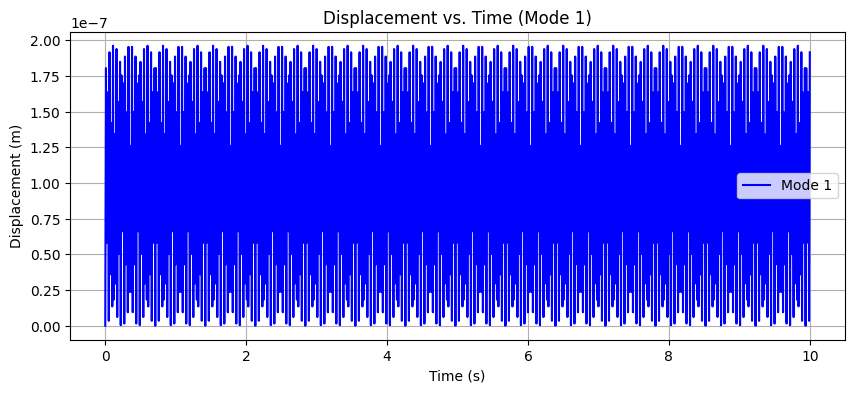

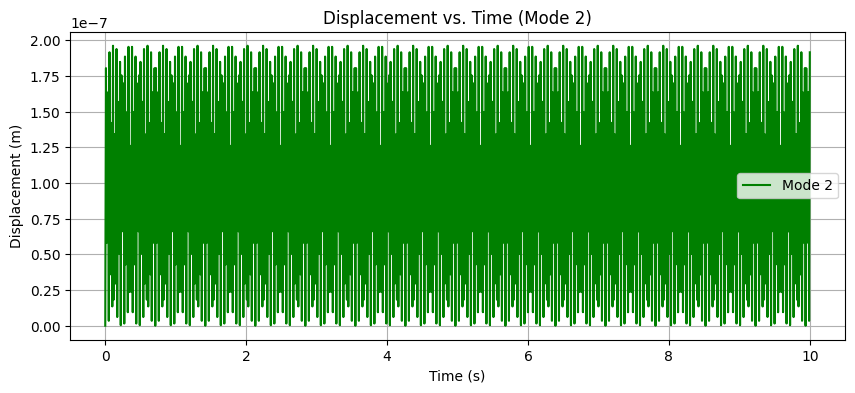

Mode 1:
  Maximum displacement: 1.9610757019270976e-07
  Maximum velocity: 9.807591702953846e-05
  Maximum acceleration: 0.09810000000000002
Mode 2:
  Maximum displacement: 1.9610757019270976e-07
  Maximum velocity: 9.807591702953846e-05
  Maximum acceleration: 0.09810000000000002

Maximum displacement considering both modes: 3.922151403854195e-07
1.9610757019270976e-07


In [17]:
# Calculate number of steps
n_steps = int(total_time / dt) + 1

# Time array
t = np.linspace(0, total_time, n_steps)

# Analytical solution for displacement
omega = np.sqrt(np.linalg.inv(M_constrained) @ K_constrained)  # Natural frequency matrix
x_analytical = np.zeros((M_constrained.shape[0], n_steps))  # Initialize displacement array

for i in range(M_constrained.shape[0]):
    x_analytical[i, :] = (f_constrained[i] / K_constrained[i, i]) * (1 - np.cos(omega[i, i] * t))

print(x_analytical.shape)

# Calculate velocity and acceleration
v_analytical = np.zeros_like(x_analytical)
a_analytical = np.zeros_like(x_analytical)

for i in range(M_constrained.shape[0]):
    v_analytical[i, :] = (f_constrained[i] / K_constrained[i, i]) * omega[i, i] * np.sin(omega[i, i] * t)
    a_analytical[i, :] = (f_constrained[i] / K_constrained[i, i]) * omega[i, i]**2 * np.cos(omega[i, i] * t)

# Plot the results for each mode separately with different colors
colors = ['b', 'g']  # Define colors for each mode
for i in range(M_constrained.shape[0]):
    plt.figure(figsize=(10, 4))
    plt.plot(t, x_analytical[i, :], color=colors[i % len(colors)], label=f'Mode {i+1}')
    plt.xlabel('Time (s)')
    plt.ylabel('Displacement (m)')
    plt.title(f'Displacement vs. Time (Mode {i+1})')
    plt.grid(True)
    plt.legend()
    plt.show()

# Print maximum values for each mode
for i in range(M_constrained.shape[0]):
    print(f"Mode {i+1}:")
    print(f"  Maximum displacement: {max(x_analytical[i, :])}")
    print(f"  Maximum velocity: {max(v_analytical[i, :])}")
    print(f"  Maximum acceleration: {max(a_analytical[i, :])}")

# Print maximum displacement considering both modes
max_displacement_combined = np.max(np.sum(x_analytical, axis=0))
print(f"\nMaximum displacement considering both modes: {max_displacement_combined}")
print(np.max(np.abs(x_analytical)))

In [20]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from pathlib import Path
from tabulate import tabulate

# Get system dimensions
n_dof = M_constrained.shape[0]  # Number of degrees of freedom
n_cases = f_constrained.shape[0]  # Number of load cases

# Define x using the same values as x_analtical
x0 = np.zeros((n_dof)) # Displacement (m) as a 1x1 matrix
print(x0.shape)
print(x0)

s = f_constrained.shape[0]
# Initialize initial velocity as zero vector
v0 = np.zeros((n_dof))  # Initial velocities (n×m)

y0 = np.vstack([x0, v0]).flatten()  # Stack initial conditions into a column vector|
print(y0.shape)
print(y0)


# Time step and total simulation time
dt = 0.01 # 3.14e-6               # Time step = T/200
total_time = 10 # 0.01          # Total simulation time

# Calculate number of steps
n_steps = int(total_time / dt) + 1

# Compute M⁻¹
M_inv = np.linalg.inv(M_constrained)

# Define system matrix A and input vector B
A = np.block([
    [np.zeros((n_dof, n_dof)), np.eye(n_dof)], 
    [-M_inv @ K_constrained, np.zeros((n_dof, n_dof))]
])

B = np.vstack([np.zeros((n_dof, 1)), M_inv @ f_constrained])

# Time span
t_span = (0, total_time)  # From t=0 to t=1
t_eval = np.linspace(0, total_time, n_steps)  # Time points where the solution is evaluated

def dUdt(t, y):
    return A @ y + B.flatten()


# Get number of cases and magnitudes
num_cases = f_constrained.shape[1]

# Create the base directory
base_dir = Path("Dynamic_solution")
base_dir.mkdir(exist_ok=True)

# Print initial information
print("Starting multi-case dynamic analysis...")
print(f"Function called with:\nM: {M_constrained.shape}, K: {K_constrained.shape}, f: {f_constrained.shape}, magnitudes: {magnitudes}, x: {x0.shape}\n")
print(f"Number of cases: {num_cases}")

# Results storage
results = []
case_times = []

# Solve the system for each case
start_time = time.time()
for case in tqdm(range(num_cases), desc="Solving cases"):
    case_start_time = time.time()
    print(f"\nSolving case {case + 1}/{num_cases}")
    magnitude = magnitudes[case]
    print(f"Magnitude: {magnitude}")
    
    # Create case folder name
    magnitude_str = ", ".join(str(val) for val in magnitude)
    case_folder = base_dir / f"case_{case+1}_magnitude_({magnitude_str})"
    analytical_folder = case_folder / "Analytical_Solution"
    analytical_folder.mkdir(parents=True, exist_ok=True)

    # Solve the system
    sol = solve_ivp(dUdt, t_span, y0, t_eval=t_eval, method='RK45', atol=1e-10, rtol=1e-10)
    
    # Extract results
    t = sol.t
    U = sol.y
    u = U[:s]  # Velocity
    v = U[s:]  # Displacement
    a = np.linalg.solve(M_constrained, f_constrained - (K_constrained @ u))  # Acceleration
    
    # Save results
    np.save(analytical_folder / 'time.npy', t)
    np.save(analytical_folder / 'displacement.npy', u)
    np.save(analytical_folder / 'velocity.npy', v)
    np.save(analytical_folder / 'acceleration.npy', a)
    
    # Store summary results
    case_time = time.time() - case_start_time
    case_times.append(case_time)
    
    results.append({
        "case": case + 1,
        "magnitude": magnitude,
        "max_displacement": np.max(np.abs(u)),
        "max_velocity": np.max(np.abs(v)),
        "max_acceleration": np.max(np.abs(a)),
        "solve_time": case_time
    })
    
    print(f"Case {case + 1} completed in {case_time:.2f} seconds.")
    print(f"Results saved to {analytical_folder}")

# Print results summary
print("\nResults Summary:")
print("=" * 80)
summary_data = [[r["case"], 
                str(r["magnitude"]), 
                f"{r['max_displacement']:.2e}",
                f"{r['max_velocity']:.2e}", 
                f"{r['max_acceleration']:.2e}",
                f"{r['solve_time']:.2f}"] for r in results]

headers = ["Case", "Magnitude", "Max Displacement", "Max Velocity", "Max Acceleration", "Solve Time (s)"]
print(tabulate(summary_data, headers=headers, tablefmt="grid"))

# Print overall statistics
total_time = sum(case_times)
print("\nOverall Statistics:")
print("=" * 80)
print(f"Total computation time: {total_time:.2f} seconds")
print(f"Average time per case: {total_time/num_cases:.2f} seconds")
print(f"Number of cases: {num_cases}")
print(f"Fastest case: {min(case_times):.2f} seconds (Case {np.argmin(case_times)+1})")
print(f"Slowest case: {max(case_times):.2f} seconds (Case {np.argmax(case_times)+1})")

# Print maximum values for each mode
for mode in range(u.shape[0]):
    print(f"Mode {mode + 1}:")
    print(f"  Maximum displacement: {np.max(np.abs(u[mode, :])):.2e}")
    print(f"  Maximum velocity: {np.max(np.abs(v[mode, :])):.2e}")
    print(f"  Maximum acceleration: {np.max(np.abs(a[mode, :])):.2e}")

print(f"\nAnalysis complete. Results saved in: {base_dir.resolve()}")

max_displacement_combined = np.sum([np.max(np.abs(u[mode, :])) for mode in range(u.shape[0])])
print(f"\nMaximum displacement considering both modes: {max_displacement_combined}")
print(np.max(np.abs(u)))

(2,)
[0. 0.]
(4,)
[0. 0. 0. 0.]
Starting multi-case dynamic analysis...
Function called with:
M: (2, 2), K: (2, 2), f: (2, 1), magnitudes: ((1.0, 2.0, 3.0),), x: (2,)

Number of cases: 1


Solving cases:   0%|          | 0/1 [00:00<?, ?it/s]


Solving case 1/1
Magnitude: (1.0, 2.0, 3.0)


Solving cases: 100%|██████████| 1/1 [00:02<00:00,  2.26s/it]

Case 1 completed in 2.25 seconds.
Results saved to Dynamic_solution\case_1_magnitude_(1.0, 2.0, 3.0)\Analytical_Solution

Results Summary:
+--------+-----------------+--------------------+----------------+--------------------+------------------+
|   Case | Magnitude       |   Max Displacement |   Max Velocity |   Max Acceleration |   Solve Time (s) |
+========+=================+====================+================+====================+==================+
|      1 | (1.0, 2.0, 3.0) |           1.96e-07 |       9.81e-05 |             0.0981 |             2.25 |
+--------+-----------------+--------------------+----------------+--------------------+------------------+

Overall Statistics:
Total computation time: 2.25 seconds
Average time per case: 2.25 seconds
Number of cases: 1
Fastest case: 2.25 seconds (Case 1)
Slowest case: 2.25 seconds (Case 1)
Mode 1:
  Maximum displacement: 1.96e-07
  Maximum velocity: 9.81e-05
  Maximum acceleration: 9.81e-02
Mode 2:
  Maximum displacement: 1.96e-

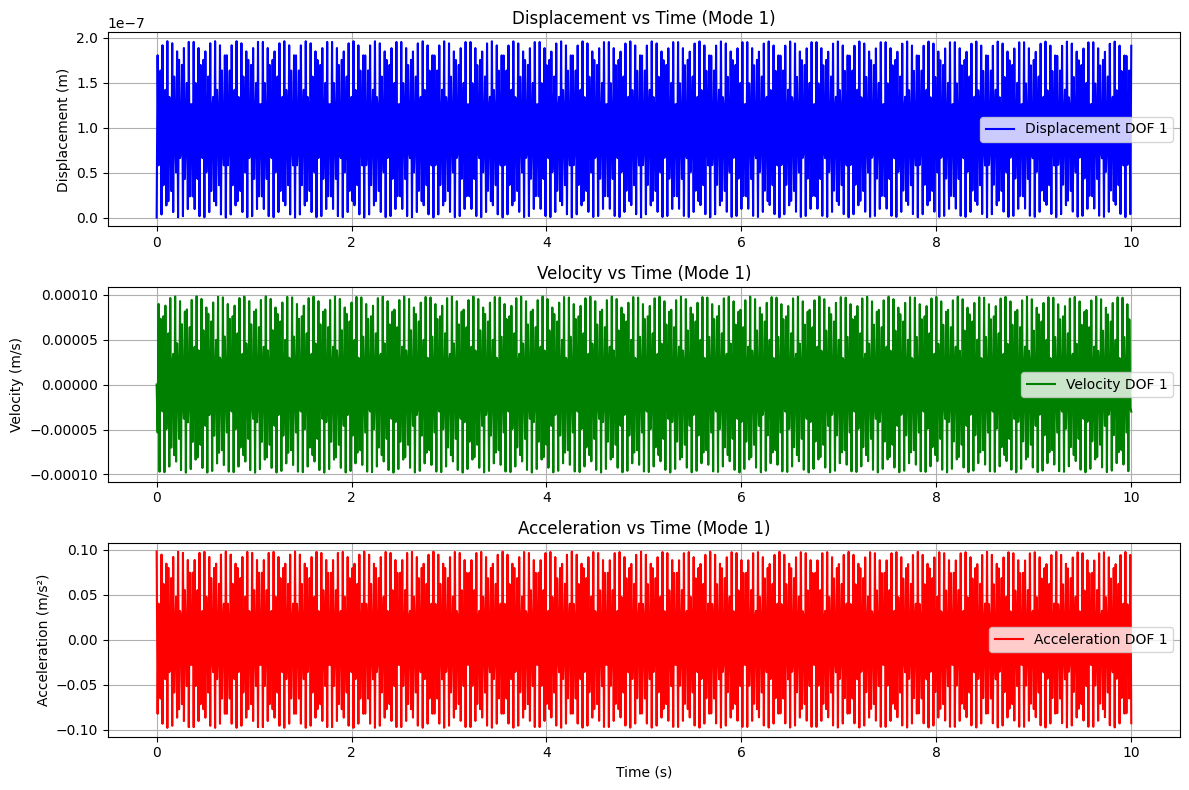

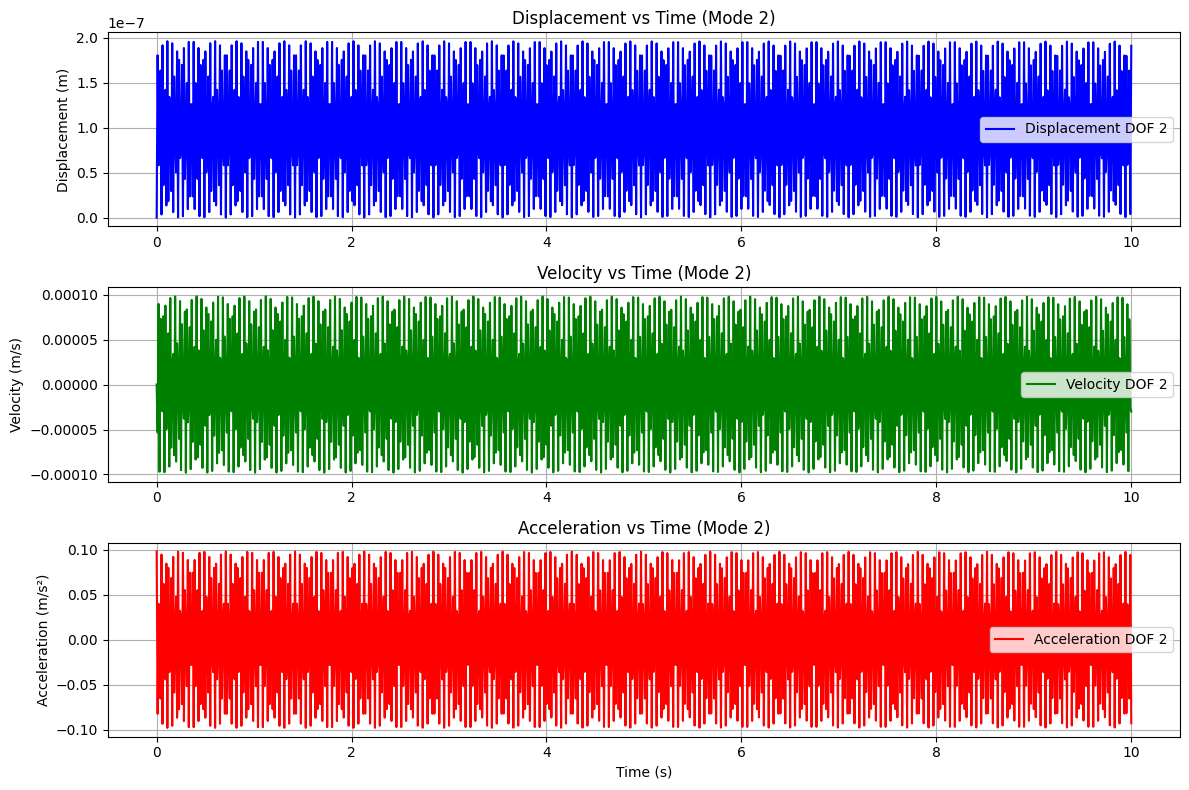

In [21]:
# Plot displacement, velocity, and acceleration for each mode separately
for i in range(n_dof):
    plt.figure(figsize=(12, 8))

    # Displacement plot
    plt.subplot(3, 1, 1)
    plt.plot(t, u[i, :], label=f'Displacement DOF {i+1}', color='b')
    plt.ylabel('Displacement (m)')
    plt.title(f'Displacement vs Time (Mode {i+1})')
    plt.grid(True)
    plt.legend()

    # Velocity plot
    plt.subplot(3, 1, 2)
    plt.plot(t, v[i, :], label=f'Velocity DOF {i+1}', color='g')
    plt.ylabel('Velocity (m/s)')
    plt.title(f'Velocity vs Time (Mode {i+1})')
    plt.grid(True)
    plt.legend()

    # Acceleration plot
    plt.subplot(3, 1, 3)
    plt.plot(t, a[i, :], label=f'Acceleration DOF {i+1}', color='r')
    plt.xlabel('Time (s)')
    plt.ylabel('Acceleration (m/s²)')
    plt.title(f'Acceleration vs Time (Mode {i+1})')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()


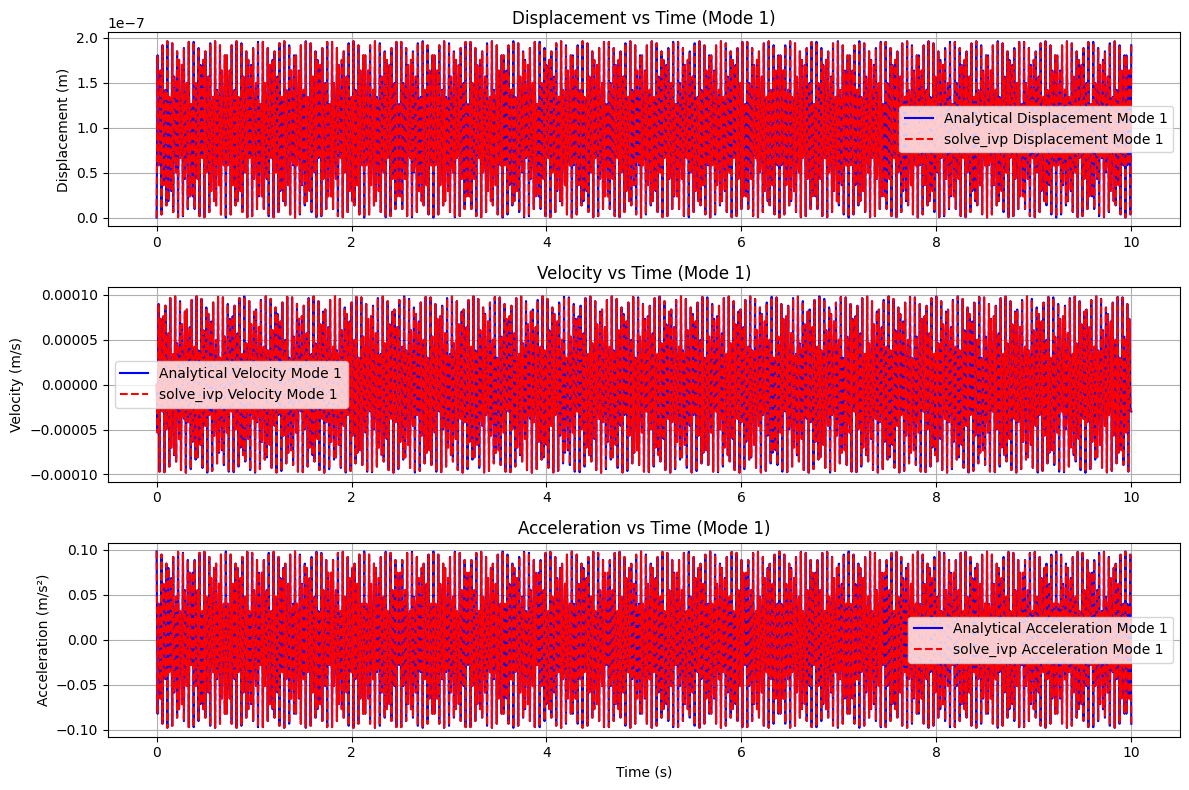

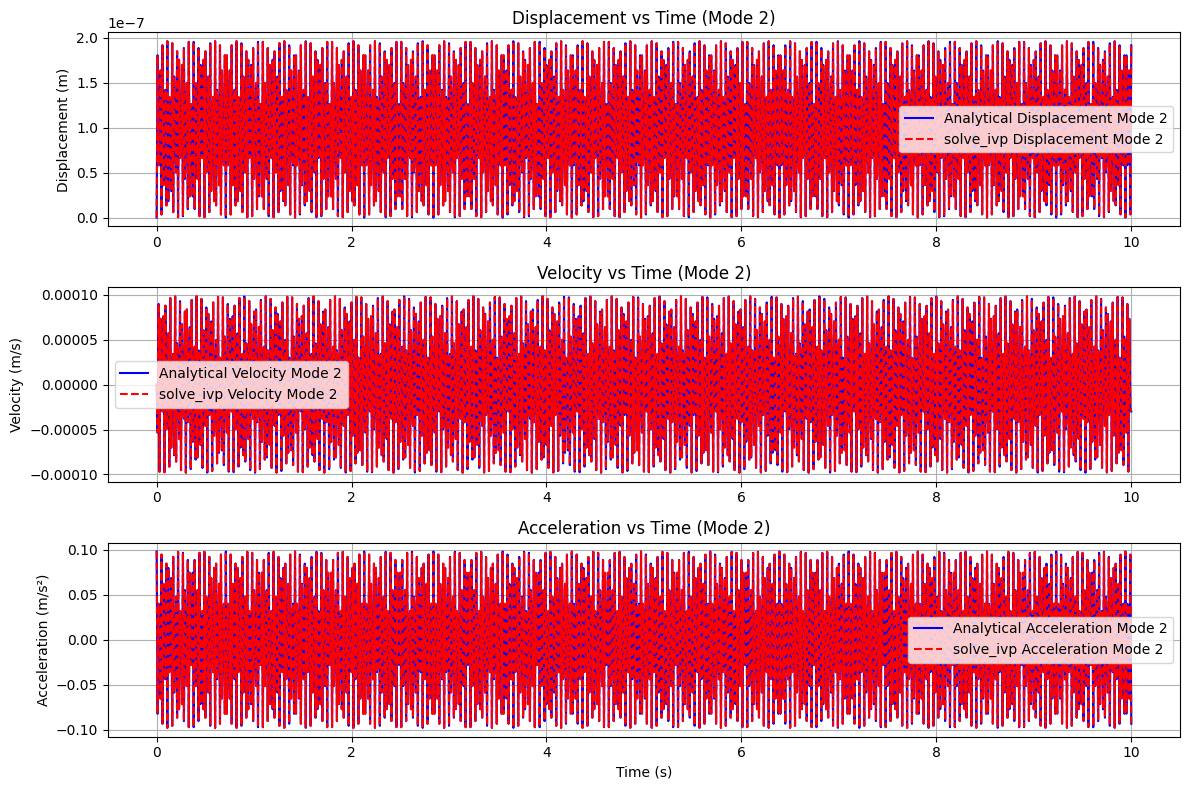

In [23]:
# Plot displacement, velocity, and acceleration for each mode separately
for i in range(n_dof):
    plt.figure(figsize=(12, 8))

    # Displacement plot
    plt.subplot(3, 1, 1)
    plt.plot(t, x_analytical[i, :], label=f'Analytical Displacement Mode {i+1}', color='b')
    plt.plot(t, u[i, :], label=f'solve_ivp Displacement Mode {i+1}', color='r', linestyle='--')
    plt.ylabel('Displacement (m)')
    plt.title(f'Displacement vs Time (Mode {i+1})')
    plt.grid(True)
    plt.legend()

    # Velocity plot
    plt.subplot(3, 1, 2)
    plt.plot(t, v_analytical[i, :], label=f'Analytical Velocity Mode {i+1}', color='b')
    plt.plot(t, v[i, :], label=f'solve_ivp Velocity Mode {i+1}', color='r', linestyle='--')
    plt.ylabel('Velocity (m/s)')
    plt.title(f'Velocity vs Time (Mode {i+1})')
    plt.grid(True)
    plt.legend()

    # Acceleration plot
    plt.subplot(3, 1, 3)
    plt.plot(t, a_analytical[i, :], label=f'Analytical Acceleration Mode {i+1}', color='b')
    plt.plot(t, a[i, :], label=f'solve_ivp Acceleration Mode {i+1}', color='r', linestyle='--')
    plt.xlabel('Time (s)')
    plt.ylabel('Acceleration (m/s²)')
    plt.title(f'Acceleration vs Time (Mode {i+1})')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

In [25]:
import numpy as np
from scipy import linalg
import os
import shutil
from pathlib import Path
from tqdm import tqdm
import time
from tabulate import tabulate

def solve_newmark_dynamic_single_case(structural_components, initial_displacement, total_time, dt, 
                                     beta, gamma, tol, max_iter):
    """
    Solve dynamic system for a single case using Newmark-β method

    Args:
        structural_components (dict): Contains system matrices (M, K, F)
        initial_displacement (np.array): Initial displacement vector for this case (1D array)
        total_time (float): Total simulation time
        dt (float): Time step size
        beta (float): Newmark-β parameter
        gamma (float): Newmark-γ parameter
        tol (float): Convergence tolerance
        max_iter (int): Maximum iterations per time step

    Returns:
        dict: Results including displacements, velocities, accelerations, etc.
    """
    # Get system matrices and force vector
    M = structural_components['M_constrained']
    K = structural_components['K_constrained']
    F = structural_components['f_constrained']
    n = M.shape[0]

    # Scale matrices to improve conditioning
    M_scale = 1.0 
    K_scale = 1.0 
    F_scale = 1.0 

    M_scaled = M / M_scale
    K_scaled = K / K_scale
    F_scaled = F / F_scale
    
    print("\nMatrix scaling factors:")
    print(f"Mass matrix scale: {M_scale:.2e}")
    print(f"Stiffness matrix scale: {K_scale:.2e}")
    print(f"Force vector scale: {F_scale:.2e}")

    # Setup time integration
    n_steps = int(total_time / dt) + 1
    t = np.linspace(0, total_time, n_steps)

    # Initialize solution arrays
    d = np.zeros((n_steps, n))  # Displacement
    v = np.zeros((n_steps, n))  # Velocity
    a = np.zeros((n_steps, n))  # Acceleration

    # Set initial displacement for this case
    d[0] = initial_displacement  # Correctly set the initial displacement

    # Initial acceleration
    # a[0] = linalg.solve(M_scaled, F_scaled[0] - K_scaled @ d[0])
    # a[0] = (F_scaled - K_scaled @ d[0]) / M_scaled  # Correct initial acceleration
    a[0] = np.linalg.solve(M_scaled, F_scaled.flatten() - (K_scaled @ d[0])) # Acceleration

    # Newmark constants (pre-calculate for efficiency)
    c1 = 1 / (beta * dt**2)
    c2 = gamma / (beta * dt)
    c3 = 1 / (beta * dt)
    c5 = (1 - 2 * beta) / (2 * beta)

    # Effective stiffness matrix (K_tan^dyn), pre-factor for efficiency
    K_eff = K_scaled + c1 * M_scaled
    K_eff_factor = linalg.lu_factor(K_eff)

    # Convergence tracking arrays
    iterations_per_step = np.zeros(n_steps, dtype=int)
    residuals_per_step = np.zeros(n_steps)
    convergence_status = np.ones(n_steps, dtype=bool)

    # Time stepping
    for i in range(1, n_steps):
        # a_pred = a[i-1].copy()  # Initial guess for a_i
        # d_pred = d[i - 1] + dt * v[i - 1] + (dt**2) * ((1 - 2 * beta) / 2 * a[i - 1] + beta * a_pred)
        # v_pred = v[i - 1] + dt * ((1 - gamma) * a[i - 1] + gamma * a_pred)
        d_pred = d[i-1] + dt*v[i-1] + (0.5-beta)*dt**2*a[i-1]
        v_pred = v[i-1] + (1-gamma)*dt*a[i-1]

        # Newton-Raphson iteration
        d[i] = d_pred.copy()  # Initial guess for displacement at i
        v[i] = v_pred.copy()  # Initial guess for velocity at i
        converged = False

        for j in range(max_iter):
            # Calculate accelerations and velocities based on x_{n+1} (Eqs. 2.17 & 2.18)
            a_i = c1 * (d[i] - d[i - 1]) - c3 * v[i - 1] - c5 * a[i - 1]
            v_i = c2 * (d[i] - d[i - 1]) - (gamma/beta - 1) * v[i-1] - (dt/2) * (gamma/beta - 2) * a[i - 1]

            # Calculate the residual force (Eq 2.19):
            R = F - M @ a_i - K @ d[i]

            residual_norm = np.linalg.norm(R)

            # Check for Convergence
            if residual_norm < tol:
                converged = True
                iterations_per_step[i] = j + 1
                residuals_per_step[i] = residual_norm
                a[i] = a_i
                v[i] = v_i
                break

            # Solve for the displacement increment (delta_d)
            try:
                delta_d = linalg.lu_solve(K_eff_factor, R)
                d[i] += delta_d
                a[i] = a_i
                v[i] = v_i
            except np.linalg.LinAlgError:
                break
        

        if not converged:
            convergence_status[i] = False
            iterations_per_step[i] = max_iter
            residuals_per_step[i] = residual_norm
            a[i] = a_i
            v[i] = v_i
    
    return {
        'time': t,
        'displacement': d,
        'velocity': v,
        'acceleration': a,
        'iterations_per_step': iterations_per_step,
        'residuals_per_step': residuals_per_step,
        'convergence_status': convergence_status,
        'scales': {'M_scale': M_scale, 'K_scale': K_scale, 'F_scale': F_scale}
    }



def analyze_and_print_results(case_results, case_times, magnitudes):
    """
    Analyze results from all cases and print detailed tabulated information
    """
    n_cases = len(case_results)
    
    # Prepare data for summary table
    summary_data = []
    convergence_data = []
    performance_data = []
    
    for idx, (results, solve_time, magnitude) in enumerate(zip(case_results, case_times, magnitudes)):
        iterations = results['iterations_per_step']
        residuals = results['residuals_per_step']
        conv_status = results['convergence_status']
        n_steps = len(results['time'])
        
        # Summary statistics
        converged_steps = np.sum(conv_status)
        non_converged = n_steps - converged_steps
        max_disp = np.max(np.abs(results['displacement']))
        max_vel = np.max(np.abs(results['velocity']))
        max_acc = np.max(np.abs(results['acceleration']))
        
        # Iteration statistics
        converged_iters = iterations[conv_status]
        avg_iters = np.mean(converged_iters) if len(converged_iters) > 0 else 0
        max_iters = np.max(iterations)
        min_iters = np.min(converged_iters) if len(converged_iters) > 0 else 0
        
        # Add to summary table
        summary_data.append([
            idx + 1,
            str(magnitude),
            f"{max_disp:.2e}",
            f"{max_vel:.2e}",
            f"{max_acc:.2e}",
            f"{solve_time:.2f}"
        ])
        
        # Add to convergence table
        convergence_data.append([
            idx + 1,
            str(magnitude),
            converged_steps,
            non_converged,
            f"{(converged_steps/n_steps)*100:.1f}%",
            f"{min_iters:.1f}",
            f"{avg_iters:.1f}",
            max_iters
        ])
        
        # Collect iteration distribution
        iter_dist = {}
        for i in range(1, max_iters + 1):
            count = np.sum(iterations == i)
            if count > 0:
                iter_dist[i] = count
        
        # Add to performance table
        performance_data.append([
            idx + 1,
            str(magnitude),
            f"{np.min(residuals):.2e}",
            f"{np.mean(residuals):.2e}",
            f"{np.max(residuals):.2e}",
            f"{solve_time/n_steps:.4f}",
            str(iter_dist)
        ])
    
    # Print Summary Table
    print("\nResults Summary:")
    print("=" * 80)
    headers = ["Case", "Magnitude", "Max Displacement", "Max Velocity", "Max Acceleration", "Solve Time (s)"]
    print(tabulate(summary_data, headers=headers, tablefmt="grid"))
    
    # Print Convergence Table
    print("\nConvergence Analysis:")
    print("=" * 80)
    headers = ["Case", "Magnitude", "Converged Steps", "Non-converged", "Success Rate", 
              "Min Iters", "Avg Iters", "Max Iters"]
    print(tabulate(convergence_data, headers=headers, tablefmt="grid"))
    
    # Print Performance Table
    print("\nPerformance Analysis:")
    print("=" * 80)
    headers = ["Case", "Magnitude", "Min Residual", "Avg Residual", "Max Residual", 
              "Time per Step (s)", "Iteration Distribution"]
    print(tabulate(performance_data, headers=headers, tablefmt="grid"))
    
    # Print Overall Statistics
    print("\nOverall Statistics:")
    print("=" * 80)
    total_time = np.sum(case_times)
    print(f"Total computation time: {total_time:.2f} seconds")
    print(f"Average time per case: {total_time/n_cases:.2f} seconds")
    print(f"Number of cases: {n_cases}")
    print(f"Fastest case: {np.min(case_times):.2f} seconds (Case {np.argmin(case_times)+1})")
    print(f"Slowest case: {np.max(case_times):.2f} seconds (Case {np.argmax(case_times)+1})")

def save_case_results(results, case_dir):
    """
    Save results for a single case with comprehensive solution storage
    """
    # Create solution directory
    solution_dir = case_dir / 'solution'
    solution_dir.mkdir(exist_ok=True)
    
    # Save raw solution arrays as .npy files
    np.save(solution_dir / 'time.npy', results['time'])
    np.save(solution_dir / 'displacement.npy', results['displacement'])
    np.save(solution_dir / 'velocity.npy', results['velocity'])
    np.save(solution_dir / 'acceleration.npy', results['acceleration'])
    
    # Save time history data in compressed format
    np.savez(case_dir / 'time_history.npz',
             time=results['time'],
             displacement=results['displacement'],
             velocity=results['velocity'],
             acceleration=results['acceleration'])
    
    # Save convergence data
    np.savez(case_dir / 'convergence_data.npz',
             iterations=results['iterations_per_step'],
             residuals=results['residuals_per_step'],
             convergence_status=results['convergence_status'])
    
    # Save scaling factors
    np.savez(case_dir / 'scaling_factors.npz', **results['scales'])
    
    # Save summary statistics
    with open(case_dir / 'summary.txt', 'w') as f:
        f.write("Results Summary:\n")
        f.write("=" * 50 + "\n")
        f.write(f"Time steps completed: {len(results['time'])}\n")
        f.write(f"Maximum displacement: {np.max(np.abs(results['displacement'])):.2e}\n")
        f.write(f"Maximum velocity: {np.max(np.abs(results['velocity'])):.2e}\n")
        f.write(f"Maximum acceleration: {np.max(np.abs(results['acceleration'])):.2e}\n")
        f.write(f"Converged steps: {np.sum(results['convergence_status'])}\n")
        f.write(f"Non-converged steps: {np.sum(~results['convergence_status'])}\n")
        f.write("\nFile Locations:\n")
        f.write("-" * 30 + "\n")
        f.write(f"Solution arrays (.npy files): {solution_dir}\n")
        f.write(f"Time history: {case_dir/'time_history.npz'}\n")
        f.write(f"Convergence data: {case_dir/'convergence_data.npz'}\n")
        f.write(f"Scaling factors: {case_dir/'scaling_factors.npz'}\n")


def solve_newmark_dynamic_multi_case(M, K, f, magnitudes, x, total_time=1.0, dt=0.01, beta=0.25, gamma=0.5, tol=1e-6, max_iter=50):
    print("Function called with:")
    print(f"M: {M.shape}, K: {K.shape}, f: {f.shape}, magnitudes: {magnitudes}, x: {x.shape}")
    # Rest of the function implementation
    """
    Solve dynamic system for multiple cases using Newmark-β method

    Args:
        M (np.array): Mass matrix
        K (np.array): Stiffness matrix
        f (np.array): Force matrix (each column corresponds to a case)
        magnitudes (list): List of magnitudes for each case
        x (np.array): Initial displacement matrix (each column corresponds to a case)
        total_time (float): Total simulation time
        dt (float): Time step size
        beta (float): Newmark-β parameter
        gamma (float): Newmark-γ parameter
        tol (float): Convergence tolerance
        max_iter (int): Maximum iterations per time step

    Returns:
        output_dir (Path): Directory where results are saved
        case_results (list): List of results for each case
        case_times (list): List of computation times for each case
    """
    output_dir = Path("Dynamic_solution")
    if output_dir.exists():
        shutil.rmtree(output_dir)
    output_dir.mkdir()
    
    n_dof = M.shape[0]
    n_cases = f.shape[1]
    
    print(f"\nStarting multi-case dynamic analysis...")
    print(f"Number of DOFs: {n_dof}")
    print(f"Number of cases: {n_cases}")
    
    # Track results and timing for each case
    case_results = []
    case_times = []
    
    for case_idx in tqdm(range(n_cases), desc="Processing cases"):
        case_dir = output_dir / f"case_{case_idx+1}_magnitude_{magnitudes[case_idx]}" / "Numerical_Solution"
        case_dir.mkdir(parents=True, exist_ok=True)
        
        structural_components = {
            'M_constrained': M,
            'K_constrained': K,
            'f_constrained': f[:, case_idx]
        }
        
        print(f"\nSolving case {case_idx+1}/{n_cases}")
        print(f"Magnitude: {magnitudes[case_idx]}")
        
        try:
            # Time the solution
            start_time = time.time()
            results = solve_newmark_dynamic_single_case(
                structural_components,
                initial_displacement=x[case_idx],  # Pass initial displacement for this case
                total_time=total_time,
                dt=dt,
                beta=beta,
                gamma=gamma,
                tol=tol,
                max_iter=max_iter
            )
            solve_time = time.time() - start_time
            
            # Store results and timing
            case_results.append(results)
            case_times.append(solve_time)
            
            # Save results
            save_case_results(results, case_dir)
            
        except Exception as e:
            print(f"Error in case {case_idx+1}: {str(e)}")
            continue
    
    # Analyze and print detailed results
    analyze_and_print_results(case_results, case_times, magnitudes)
    
    return output_dir, case_results, case_times

if __name__ == "__main__":
    try:
        print("Starting multi-case dynamic analysis...")
        
        output_dir, case_results, case_times = solve_newmark_dynamic_multi_case(
            M=M_constrained,
            K=K_constrained,
            f=f_constrained,
            magnitudes=magnitudes,
            x=x0,  
            total_time=10, #0.01, #0.01,
            dt= 0.01, #3.14e-6, #3.14e-6, #0.05, # 
            beta=0.25,
            gamma=0.5,
            tol=1e-8,
            max_iter=50
        )
        
        print(f"\nAnalysis complete. Results saved in: {output_dir}")
        
    except Exception as e:
        print(f"Error in dynamic analysis: {str(e)}")
        import traceback
        traceback.print_exc()

Starting multi-case dynamic analysis...
Function called with:
M: (2, 2), K: (2, 2), f: (2, 1), magnitudes: ((1.0, 2.0, 3.0),), x: (2,)

Starting multi-case dynamic analysis...
Number of DOFs: 2
Number of cases: 1


Processing cases: 100%|██████████| 1/1 [00:00<00:00, 23.03it/s]


Solving case 1/1
Magnitude: (1.0, 2.0, 3.0)

Matrix scaling factors:
Mass matrix scale: 1.00e+00
Stiffness matrix scale: 1.00e+00
Force vector scale: 1.00e+00

Results Summary:
+--------+-----------------+--------------------+----------------+--------------------+------------------+
|   Case | Magnitude       |   Max Displacement |   Max Velocity |   Max Acceleration |   Solve Time (s) |
+========+=================+====================+================+====================+==================+
|      1 | (1.0, 2.0, 3.0) |           1.96e-07 |       9.81e-05 |             0.0981 |             0.04 |
+--------+-----------------+--------------------+----------------+--------------------+------------------+

Convergence Analysis:
+--------+-----------------+-------------------+-----------------+----------------+-------------+-------------+-------------+
|   Case | Magnitude       |   Converged Steps |   Non-converged | Success Rate   |   Min Iters |   Avg Iters |   Max Iters |
+========+==

In [32]:
# Calculate absolute and relative differences for displacement
displacement_diff_abs = np.abs(case_results[0]['displacement'] - x_analytical.T)
displacement_diff_rel = np.abs(displacement_diff_abs / x_analytical.T) * 100

# Calculate absolute and relative differences for velocity
velocity_diff_abs = np.abs(case_results[0]['velocity'] - v_analytical.T)
velocity_diff_rel = np.abs(velocity_diff_abs / v_analytical.T) * 100

# Calculate absolute and relative differences for acceleration
acceleration_diff_abs = np.abs(case_results[0]['acceleration'] - a_analytical.T)
acceleration_diff_rel = np.abs(acceleration_diff_abs / a_analytical.T) * 100

# Print maximum absolute and relative differences for each quantity
print("Displacement Differences:")
for i, (abs_diff) in enumerate(displacement_diff_abs):
    print(f"Time Step {i + 1}:")
    print(f"  Difference: {abs_diff} m")
# print(f"  Maximum Relative Difference: {np.max(displacement_diff_rel):.6f} %")

print("\nVelocity Differences:")
print(f"  Maximum Absolute Difference: {np.max(velocity_diff_abs):.6e} m/s")
print(f"  Maximum Relative Difference: {np.max(velocity_diff_rel):.6f} %")

print("\nAcceleration Differences:")
print(f"  Maximum Absolute Difference: {np.max(acceleration_diff_abs):.6e} m/s²")
print(f"  Maximum Relative Difference: {np.max(acceleration_diff_rel):.6f} %")

Displacement Differences:
Time Step 1:
  Difference: [0. 0.] m
Time Step 2:
  Difference: [8.24092915e-09 8.24092915e-09] m
Time Step 3:
  Difference: [2.90434811e-08 2.90434811e-08] m
Time Step 4:
  Difference: [5.21037559e-08 5.21037559e-08] m
Time Step 5:
  Difference: [6.46057177e-08 6.46057177e-08] m
Time Step 6:
  Difference: [5.61759597e-08 5.61759597e-08] m
Time Step 7:
  Difference: [2.3199313e-08 2.3199313e-08] m
Time Step 8:
  Difference: [2.90439945e-08 2.90439945e-08] m
Time Step 9:
  Difference: [8.72572726e-08 8.72572726e-08] m
Time Step 10:
  Difference: [1.33865742e-07 1.33865742e-07] m
Time Step 11:
  Difference: [1.52494396e-07 1.52494396e-07] m
Time Step 12:
  Difference: [1.33449756e-07 1.33449756e-07] m
Time Step 13:
  Difference: [7.74086648e-08 7.74086648e-08] m
Time Step 14:
  Difference: [3.96066701e-09 3.96066701e-09] m
Time Step 15:
  Difference: [9.0774309e-08 9.0774309e-08] m
Time Step 16:
  Difference: [1.60362337e-07 1.60362337e-07] m
Time Step 17:
  Dif

C:\Users\shrey\AppData\Local\Temp\ipykernel_36868\2241622996.py:3: RuntimeWarning: invalid value encountered in divide
  displacement_diff_rel = np.abs(displacement_diff_abs / x_analytical.T) * 100
C:\Users\shrey\AppData\Local\Temp\ipykernel_36868\2241622996.py:7: RuntimeWarning: invalid value encountered in divide
  velocity_diff_rel = np.abs(velocity_diff_abs / v_analytical.T) * 100


In [35]:
print(case_results[0]['displacement'])

[[0.00000000e+00 0.00000000e+00]
 [1.88653846e-07 1.88653846e-07]
 [2.90236686e-08 2.90236686e-08]
 ...
 [1.24109425e-07 1.24109425e-07]
 [1.10471768e-07 1.10471768e-07]
 [4.92503886e-08 4.92503886e-08]]


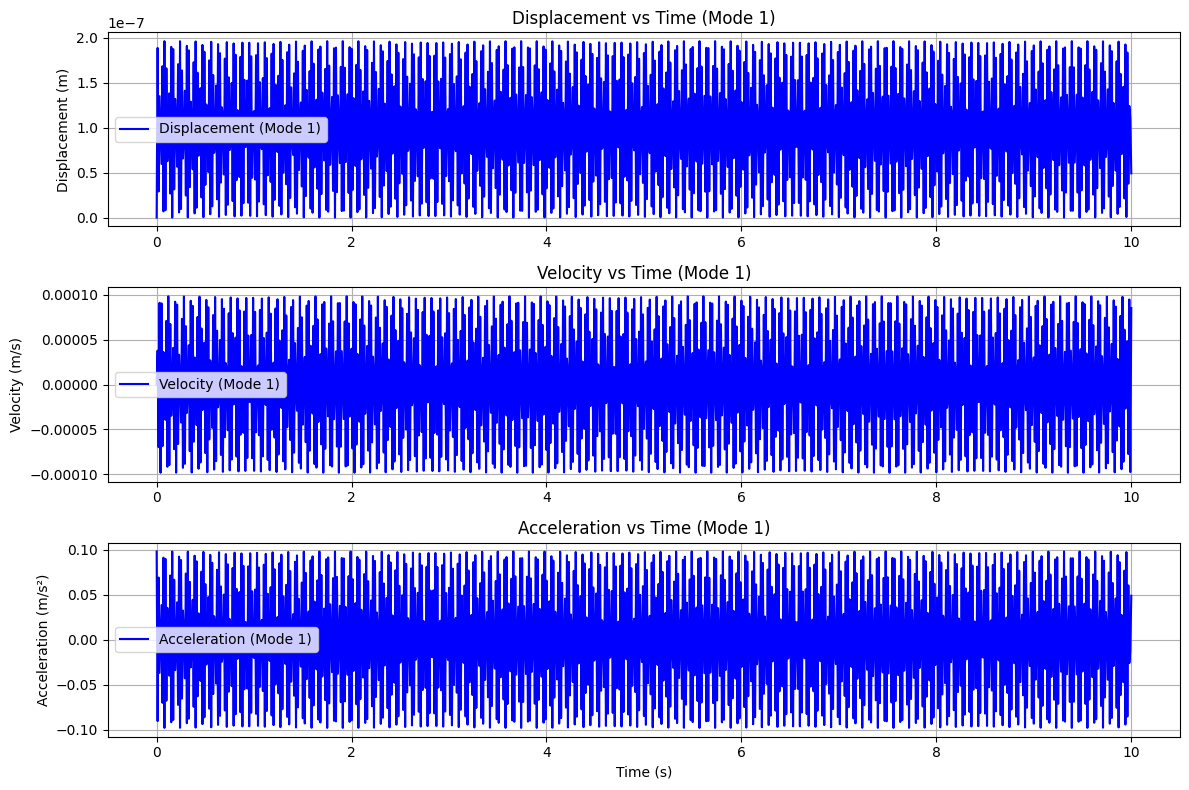

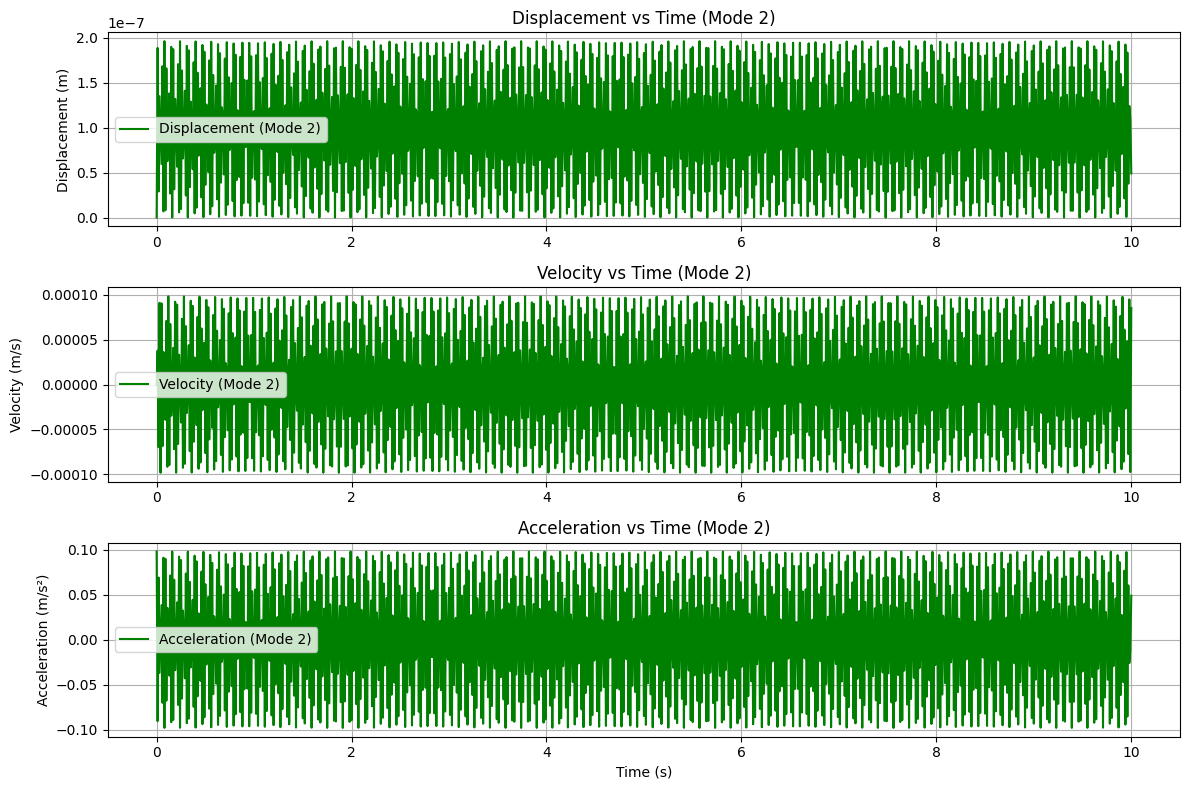

In [26]:
# Plot displacement, velocity, and acceleration for each mode separately
for mode in range(n_dof):
    plt.figure(figsize=(12, 8))

    # Displacement plot
    plt.subplot(3, 1, 1)
    plt.plot(t, case_results[0]['displacement'][:, mode], label=f'Displacement (Mode {mode + 1})', color=colors[mode % len(colors)])
    plt.ylabel('Displacement (m)')
    plt.title(f'Displacement vs Time (Mode {mode + 1})')
    plt.grid(True)
    plt.legend()

    # Velocity plot
    plt.subplot(3, 1, 2)
    plt.plot(t, case_results[0]['velocity'][:, mode], label=f'Velocity (Mode {mode + 1})', color=colors[mode % len(colors)])
    plt.ylabel('Velocity (m/s)')
    plt.title(f'Velocity vs Time (Mode {mode + 1})')
    plt.grid(True)
    plt.legend()

    # Acceleration plot
    plt.subplot(3, 1, 3)
    plt.plot(t, case_results[0]['acceleration'][:, mode], label=f'Acceleration (Mode {mode + 1})', color=colors[mode % len(colors)])
    plt.xlabel('Time (s)')
    plt.ylabel('Acceleration (m/s²)')
    plt.title(f'Acceleration vs Time (Mode {mode + 1})')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

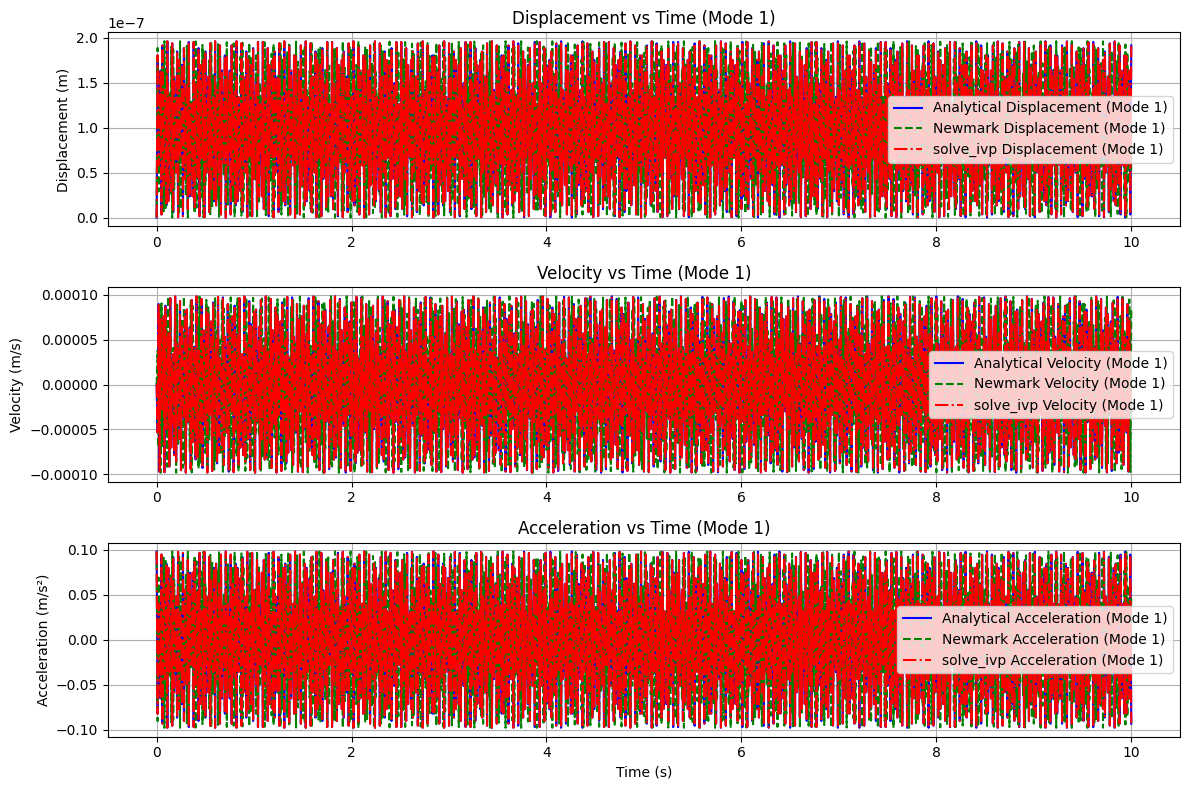

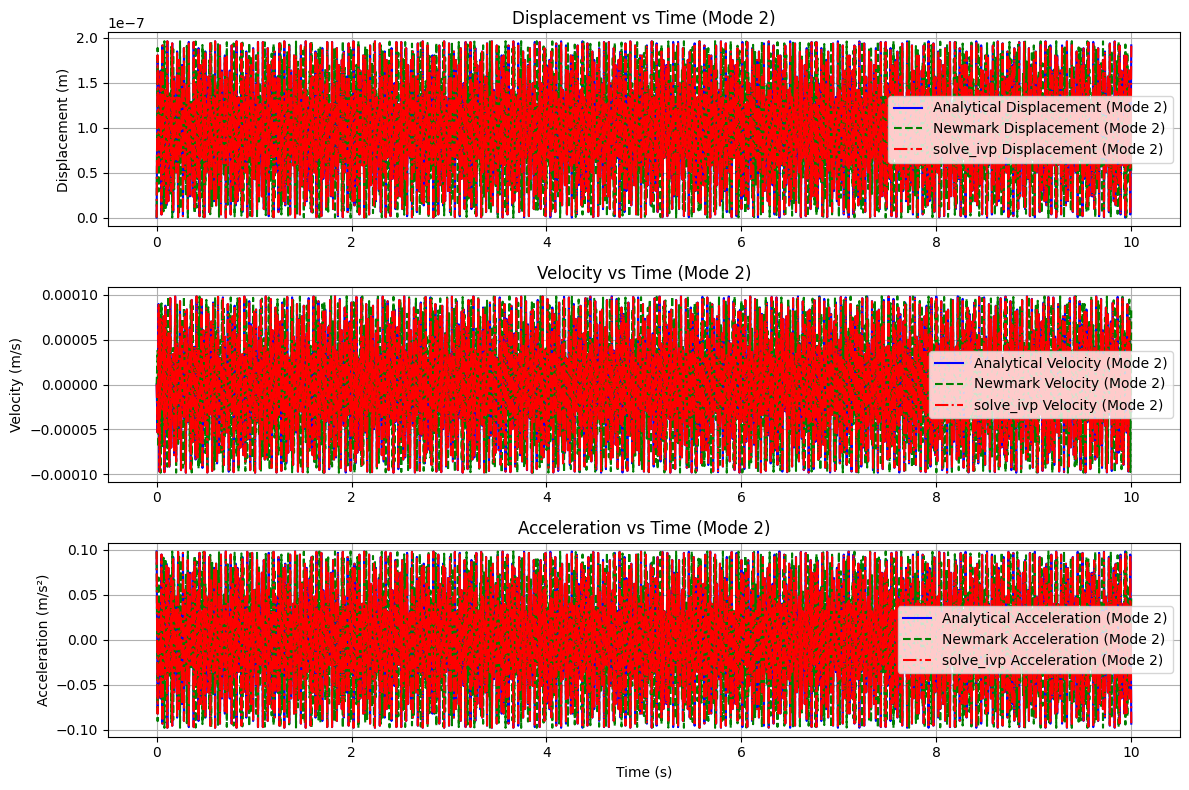

In [27]:
# Overlaying graphs to compare analytical, solve_ivp, and Newmark results
for mode in range(n_dof):
    plt.figure(figsize=(12, 8))

    # Displacement plot
    plt.subplot(3, 1, 1)
    plt.plot(t, x_analytical[mode, :], label=f'Analytical Displacement (Mode {mode + 1})', color='b')
    plt.plot(t, case_results[0]['displacement'][:, mode], label=f'Newmark Displacement (Mode {mode + 1})', color='g', linestyle='--')
    plt.plot(t, u[mode, :], label=f'solve_ivp Displacement (Mode {mode + 1})', color='r', linestyle='-.')
    plt.ylabel('Displacement (m)')
    plt.title(f'Displacement vs Time (Mode {mode + 1})')
    plt.grid(True)
    plt.legend()

    # Velocity plot
    plt.subplot(3, 1, 2)
    plt.plot(t, v_analytical[mode, :], label=f'Analytical Velocity (Mode {mode + 1})', color='b')
    plt.plot(t, case_results[0]['velocity'][:, mode], label=f'Newmark Velocity (Mode {mode + 1})', color='g', linestyle='--')
    plt.plot(t, v[mode, :], label=f'solve_ivp Velocity (Mode {mode + 1})', color='r', linestyle='-.')
    plt.ylabel('Velocity (m/s)')
    plt.title(f'Velocity vs Time (Mode {mode + 1})')
    plt.grid(True)
    plt.legend()

    # Acceleration plot
    plt.subplot(3, 1, 3)
    plt.plot(t, a_analytical[mode, :], label=f'Analytical Acceleration (Mode {mode + 1})', color='b')
    plt.plot(t, case_results[0]['acceleration'][:, mode], label=f'Newmark Acceleration (Mode {mode + 1})', color='g', linestyle='--')
    plt.plot(t, a[mode, :], label=f'solve_ivp Acceleration (Mode {mode + 1})', color='r', linestyle='-.')
    plt.xlabel('Time (s)')
    plt.ylabel('Acceleration (m/s²)')
    plt.title(f'Acceleration vs Time (Mode {mode + 1})')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

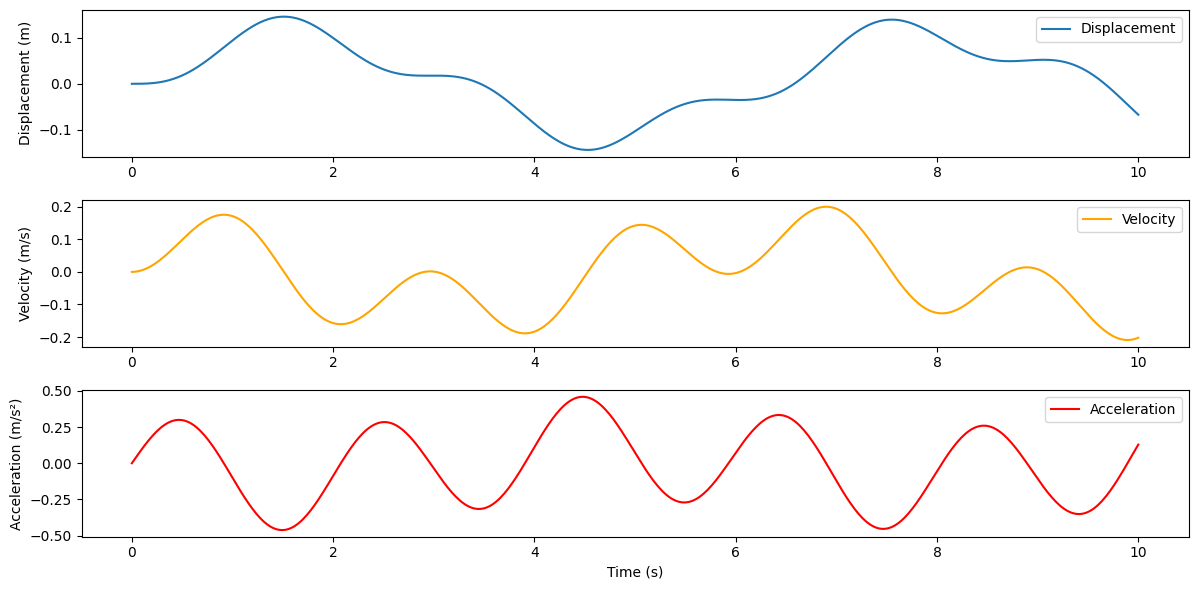

Number of converged steps using Newton-Raphson: 500 / 500
Iterations per time step:
Time step 1: 2 iterations
Time step 2: 2 iterations
Time step 3: 2 iterations
Time step 4: 2 iterations
Time step 5: 2 iterations
Time step 6: 2 iterations
Time step 7: 2 iterations
Time step 8: 2 iterations
Time step 9: 2 iterations
Time step 10: 2 iterations
Time step 11: 2 iterations
Time step 12: 2 iterations
Time step 13: 2 iterations
Time step 14: 2 iterations
Time step 15: 2 iterations
Time step 16: 2 iterations
Time step 17: 2 iterations
Time step 18: 2 iterations
Time step 19: 2 iterations
Time step 20: 2 iterations
Time step 21: 2 iterations
Time step 22: 2 iterations
Time step 23: 2 iterations
Time step 24: 2 iterations
Time step 25: 2 iterations
Time step 26: 2 iterations
Time step 27: 2 iterations
Time step 28: 2 iterations
Time step 29: 2 iterations
Time step 30: 2 iterations
Time step 31: 2 iterations
Time step 32: 2 iterations
Time step 33: 2 iterations
Time step 34: 2 iterations
Time st

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
m = 1.0  # Mass (kg)
c = 0.0  # Damping coefficient (Ns/m), set to zero for undamped system
k = 10.0  # Stiffness (N/m)
F0 = 1.0  # Amplitude of external force (N)
omega = 1.0  # Frequency of external force (rad/s)

# Newmark-beta parameters
alpha = 0.25
beta = 0.5

dt = 0.02  # Time step (s)
t_total = 10  # Total time (s)
time_steps = int(t_total / dt)

t = np.linspace(0, t_total, time_steps + 1)

# Initial conditions
x = np.zeros(time_steps + 1)
xdot = np.zeros(time_steps + 1)
xddot = np.zeros(time_steps + 1)

# Effective stiffness matrix
k_eff = m / (alpha * dt**2) + k

converged_steps = 0
iterations_per_step = []

def force(t):
    return F0 * np.sin(omega * t)

# Time-stepping loop
for i in range(time_steps):
    # Predictor step (initial guess for Newton-Raphson)
    x_pred = x[i]
    xdot_pred = xdot[i]
    xddot_pred = xddot[i]

    F_ext = force(t[i + 1])

    # Initial guess for displacement (Newton-Raphson)
    x_new = x_pred
    tol = 1e-6
    max_iter = 100
    num_iterations = 0

    for iteration in range(max_iter):
        num_iterations += 1

        # Compute effective force
        F_eff = F_ext + m * (x_pred / (alpha * dt**2) + xdot_pred / (alpha * dt) + (1 / (2 * alpha) - 1) * xddot_pred)

        # Compute residual
        R = k_eff * x_new - F_eff

        # Compute the tangent stiffness (Jacobian)
        K_tangent = k_eff

        # Newton-Raphson update
        delta_x = -R / K_tangent
        x_new += delta_x

        # Check convergence
        if abs(delta_x) < tol:
            converged_steps += 1
            break

    iterations_per_step.append(num_iterations)

    # Update accelerations and velocities using Newmark formulas
    xddot[i + 1] = (x_new - x[i]) / (alpha * dt**2) - xdot[i] / (alpha * dt) - ((1 / (2 * alpha) - 1) * xddot[i])
    xdot[i + 1] = xdot[i] + dt * ((1 - beta) * xddot[i] + beta * xddot[i + 1])
    x[i + 1] = x_new

# Plotting results
plt.figure(figsize=(12, 6))
plt.subplot(3, 1, 1)
plt.plot(t, x, label='Displacement')
plt.ylabel('Displacement (m)')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(t, xdot, label='Velocity', color='orange')
plt.ylabel('Velocity (m/s)')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(t, xddot, label='Acceleration', color='red')
plt.ylabel('Acceleration (m/s²)')
plt.legend()
plt.xlabel('Time (s)')

plt.tight_layout()
plt.show()

print(f'Number of converged steps using Newton-Raphson: {converged_steps} / {time_steps}')

# Display the number of iterations for each time step
print('Iterations per time step:')
for i, iters in enumerate(iterations_per_step):
    print(f'Time step {i+1}: {iters} iterations')


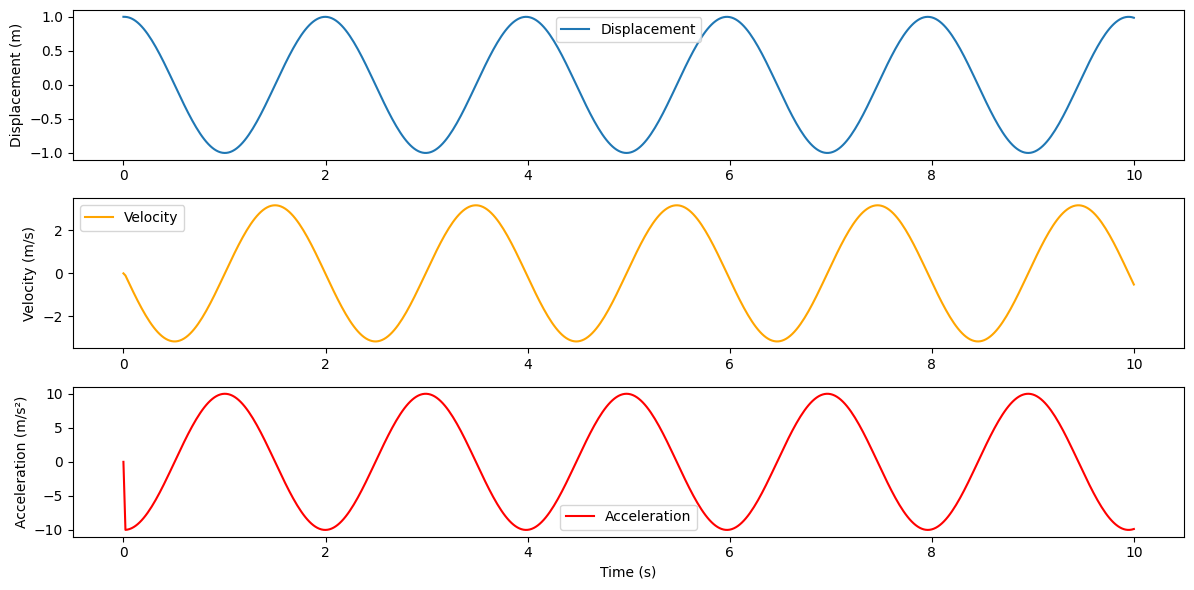

Number of converged steps using Newton-Raphson: 500 / 500
Iterations per time step:
Time step 1: 2 iterations
Time step 2: 2 iterations
Time step 3: 2 iterations
Time step 4: 2 iterations
Time step 5: 2 iterations
Time step 6: 2 iterations
Time step 7: 2 iterations
Time step 8: 2 iterations
Time step 9: 2 iterations
Time step 10: 2 iterations
Time step 11: 2 iterations
Time step 12: 2 iterations
Time step 13: 2 iterations
Time step 14: 2 iterations
Time step 15: 2 iterations
Time step 16: 2 iterations
Time step 17: 2 iterations
Time step 18: 2 iterations
Time step 19: 2 iterations
Time step 20: 2 iterations
Time step 21: 2 iterations
Time step 22: 2 iterations
Time step 23: 2 iterations
Time step 24: 2 iterations
Time step 25: 2 iterations
Time step 26: 2 iterations
Time step 27: 2 iterations
Time step 28: 2 iterations
Time step 29: 2 iterations
Time step 30: 2 iterations
Time step 31: 2 iterations
Time step 32: 2 iterations
Time step 33: 2 iterations
Time step 34: 2 iterations
Time st

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
m = 1.0  # Mass (kg)
c = 0.0  # Damping coefficient (Ns/m), set to zero for undamped system
k = 10.0  # Stiffness (N/m)
F0 = 0.0  # Amplitude of external force (N) - Set to zero
omega = 1.0  # Frequency of external force (rad/s)

# Newmark-beta parameters
alpha = 0.25
beta = 0.5

dt = 0.02  # Time step (s)
t_total = 10  # Total time (s)
time_steps = int(t_total / dt)

t = np.linspace(0, t_total, time_steps + 1)

# Initial conditions
x = np.zeros(time_steps + 1)
xdot = np.zeros(time_steps + 1)
xddot = np.zeros(time_steps + 1)

# Set initial displacement
x[0] = 1.0  # Initial displacement (m)

# Effective stiffness matrix
k_eff = m / (alpha * dt**2) + k

converged_steps = 0
iterations_per_step = []

def force(t):
    return 0.0  # No external force applied

# Time-stepping loop
for i in range(time_steps):
    # Predictor step (initial guess for Newton-Raphson)
    x_pred = x[i]
    xdot_pred = xdot[i]
    xddot_pred = xddot[i]

    F_ext = force(t[i + 1])  # Always zero in this case

    # Initial guess for displacement (Newton-Raphson)
    x_new = x_pred
    tol = 1e-6
    max_iter = 100
    num_iterations = 0

    for iteration in range(max_iter):
        num_iterations += 1

        # Compute effective force
        F_eff = F_ext + m * (x_pred / (alpha * dt**2) + xdot_pred / (alpha * dt) + (1 / (2 * alpha) - 1) * xddot_pred)

        # Compute residual
        R = k_eff * x_new - F_eff

        # Compute the tangent stiffness (Jacobian)
        K_tangent = k_eff

        # Newton-Raphson update
        delta_x = -R / K_tangent
        x_new += delta_x

        # Check convergence
        if abs(delta_x) < tol:
            converged_steps += 1
            break

    iterations_per_step.append(num_iterations)

    # Update accelerations and velocities using Newmark formulas
    xddot[i + 1] = (x_new - x[i]) / (alpha * dt**2) - xdot[i] / (alpha * dt) - ((1 / (2 * alpha) - 1) * xddot[i])
    xdot[i + 1] = xdot[i] + dt * ((1 - beta) * xddot[i] + beta * xddot[i + 1])
    x[i + 1] = x_new

# Plotting results
plt.figure(figsize=(12, 6))
plt.subplot(3, 1, 1)
plt.plot(t, x, label='Displacement')
plt.ylabel('Displacement (m)')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(t, xdot, label='Velocity', color='orange')
plt.ylabel('Velocity (m/s)')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(t, xddot, label='Acceleration', color='red')
plt.ylabel('Acceleration (m/s²)')
plt.legend()
plt.xlabel('Time (s)')

plt.tight_layout()
plt.show()

print(f'Number of converged steps using Newton-Raphson: {converged_steps} / {time_steps}')

# Display the number of iterations for each time step
print('Iterations per time step:')
for i, iters in enumerate(iterations_per_step):
    print(f'Time step {i+1}: {iters} iterations')


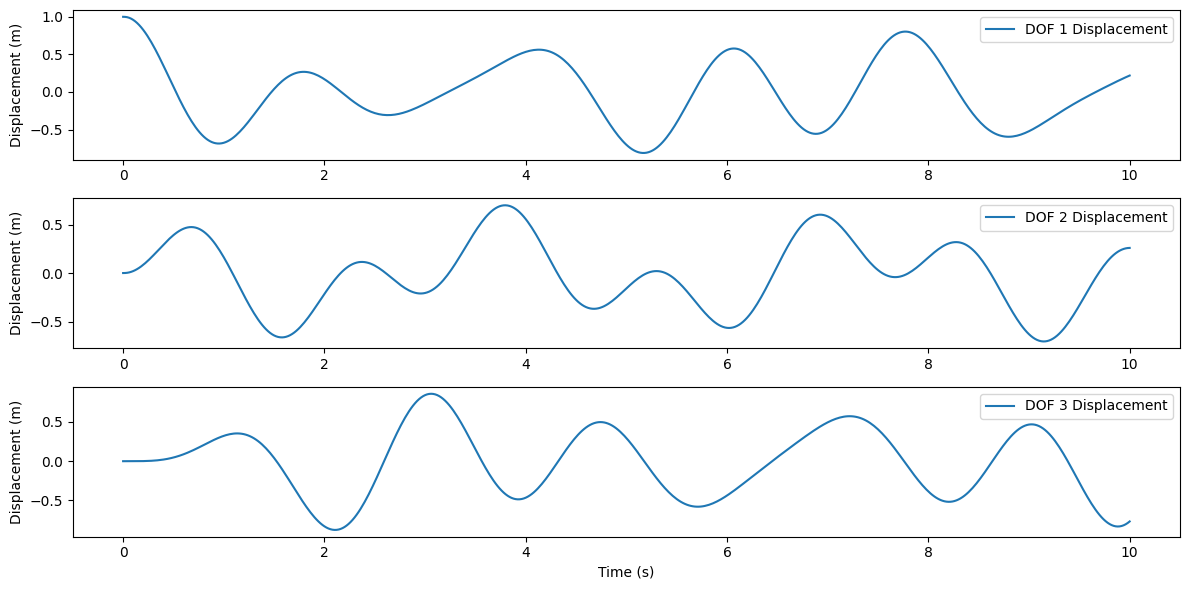

Number of converged steps using Newton-Raphson: 500 / 500
Iterations per time step:
Time step 1: 2 iterations
Time step 2: 2 iterations
Time step 3: 2 iterations
Time step 4: 2 iterations
Time step 5: 2 iterations
Time step 6: 2 iterations
Time step 7: 2 iterations
Time step 8: 2 iterations
Time step 9: 2 iterations
Time step 10: 2 iterations
Time step 11: 2 iterations
Time step 12: 2 iterations
Time step 13: 2 iterations
Time step 14: 2 iterations
Time step 15: 2 iterations
Time step 16: 2 iterations
Time step 17: 2 iterations
Time step 18: 2 iterations
Time step 19: 2 iterations
Time step 20: 2 iterations
Time step 21: 2 iterations
Time step 22: 2 iterations
Time step 23: 2 iterations
Time step 24: 2 iterations
Time step 25: 2 iterations
Time step 26: 2 iterations
Time step 27: 2 iterations
Time step 28: 2 iterations
Time step 29: 2 iterations
Time step 30: 2 iterations
Time step 31: 2 iterations
Time step 32: 2 iterations
Time step 33: 2 iterations
Time step 34: 2 iterations
Time st

In [16]:
# Newmark-Beta Method Implementation for MDOF Spring-Mass System with Newton-Raphson Iteration

import numpy as np
import matplotlib.pyplot as plt

# System parameters
n = 3  # Number of degrees of freedom

m = np.eye(n)  # Mass matrix (identity for simplicity)
k = np.array([[10, -5, 0], [-5, 10, -5], [0, -5, 10]])  # Stiffness matrix

# External force vector (sinusoidal force applied only to the first DOF)
F0 = np.zeros(n)
F0[0] = 0.0
omega = 2.0  # Frequency of external force (rad/s)

# Newmark-beta parameters
alpha = 0.25
beta = 0.5

dt = 0.02  # Time step (s)
t_total = 10  # Total time (s)
time_steps = int(t_total / dt)

t = np.linspace(0, t_total, time_steps + 1)

# Initial conditions
x = np.zeros((n, time_steps + 1))
xdot = np.zeros((n, time_steps + 1))
xddot = np.zeros((n, time_steps + 1))

# Set initial displacement (for testing, first DOF is displaced)
x[:, 0] = [1.0, 0.0, 0.0]

# Effective stiffness matrix
K_eff = (m / (alpha * dt**2)) + k

converged_steps = 0
iterations_per_step = []

# Define external force function

def force(t):
    return F0 * np.sin(omega * t)

# Time-stepping loop
for i in range(time_steps):
    # Predictor step (initial guess for Newton-Raphson)
    x_pred = x[:, i]
    xdot_pred = xdot[:, i]
    xddot_pred = xddot[:, i]

    F_ext = force(t[i + 1])  # Applied force at the next time step

    # Initial guess for displacement (Newton-Raphson)
    x_new = x_pred.copy()
    tol = 1e-6
    max_iter = 100
    num_iterations = 0

    for iteration in range(max_iter):
        num_iterations += 1

        # Compute effective force
        F_eff = F_ext + m @ (x_pred / (alpha * dt**2) + xdot_pred / (alpha * dt) + (1 / (2 * alpha) - 1) * xddot_pred)

        # Compute residual
        R = K_eff @ x_new - F_eff

        # Compute the tangent stiffness (Jacobian)
        K_tangent = K_eff

        # Newton-Raphson update
        delta_x = np.linalg.solve(K_tangent, -R)
        x_new += delta_x

        # Check convergence
        if np.linalg.norm(delta_x) < tol:
            converged_steps += 1
            break

    iterations_per_step.append(num_iterations)

    # Update accelerations and velocities using Newmark formulas
    xddot[:, i + 1] = (x_new - x[:, i]) / (alpha * dt**2) - xdot[:, i] / (alpha * dt) - ((1 / (2 * alpha) - 1) * xddot[:, i])
    xdot[:, i + 1] = xdot[:, i] + dt * ((1 - beta) * xddot[:, i] + beta * xddot[:, i + 1])
    x[:, i + 1] = x_new

# Plotting results
plt.figure(figsize=(12, 6))

for j in range(n):
    plt.subplot(n, 1, j+1)
    plt.plot(t, x[j, :], label=f'DOF {j+1} Displacement')
    plt.ylabel('Displacement (m)')
    plt.legend()

plt.xlabel('Time (s)')
plt.tight_layout()
plt.show()

print(f'Number of converged steps using Newton-Raphson: {converged_steps} / {time_steps}')

# Display the number of iterations for each time step
print('Iterations per time step:')
for i, iters in enumerate(iterations_per_step):
    print(f'Time step {i+1}: {iters} iterations')


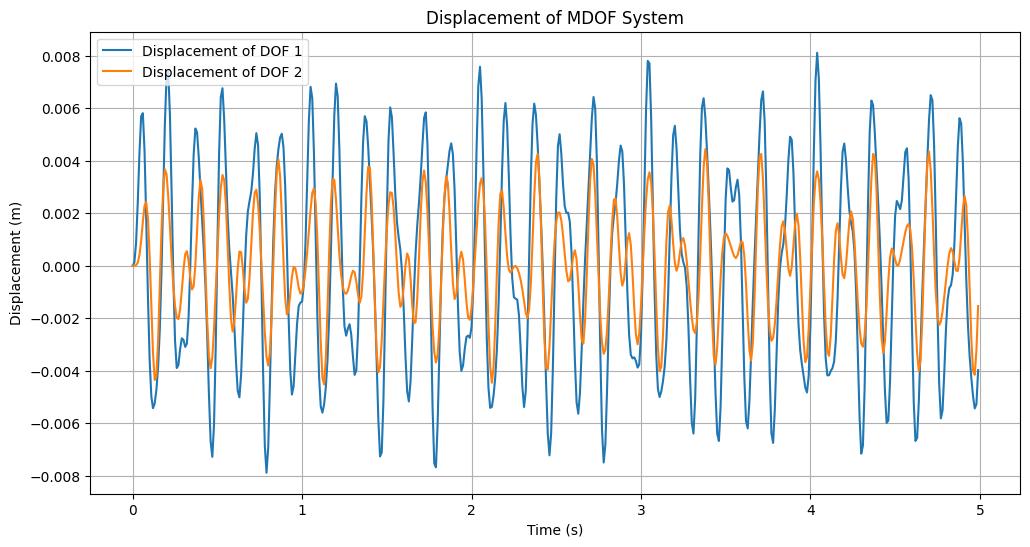

In [17]:
# MDOF System Solver using State-Space Approach

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint


def mdof_system_dynamics(y, t, M, K, F, w_f):
    """
    Defines the equations of motion for an MDOF system using state-space representation.

    Args:
        y (np.array): State vector containing displacement and velocity [x, x_dot].
        t (float): Current time step.
        M (np.array): Mass matrix.
        K (np.array): Stiffness matrix.
        F (np.array): External force vector.
        w_f (np.array): Frequency of applied forces.

    Returns:
        np.array: Derivative of the state vector.
    """
    n = M.shape[0]
    x = y[:n]
    x_dot = y[n:]

    # External forces (assuming harmonic forces)
    F_t = F * np.sin(2 * np.pi * w_f * t)

    # Compute acceleration
    x_ddot = np.linalg.solve(M, F_t - K @ x)

    # Return the derivative of the state vector
    return np.concatenate((x_dot, x_ddot))


def solve_mdof(M, K, F, w_f, initial_displacement, initial_velocity, total_time, dt):
    """
    Solves the MDOF dynamic system using the state-space approach.

    Args:
        M (np.array): Mass matrix.
        K (np.array): Stiffness matrix.
        F (np.array): External force vector (constant for all DOFs).
        w_f (np.array): Frequencies of the applied forces.
        initial_displacement (np.array): Initial displacement vector.
        initial_velocity (np.array): Initial velocity vector.
        total_time (float): Total simulation time.
        dt (float): Time step size.

    Returns:
        np.array, np.array: Time vector and solution matrix.
    """
    n = M.shape[0]
    y0 = np.concatenate((initial_displacement, initial_velocity))

    # Time vector
    time = np.arange(0, total_time, dt)

    # Solve using odeint
    sol = odeint(mdof_system_dynamics, y0, time, args=(M, K, F, w_f))

    # Extract displacement and velocity
    displacement = sol[:, :n]
    velocity = sol[:, n:]

    return time, displacement, velocity


# Example Usage
M = np.array([[1, 0], [0, 2]])  # Mass matrix
K = np.array([[6000, -2000], [-2000, 8000]])  # Stiffness matrix
F = np.array([20, 0])  # External force applied only to first DOF
w_f = np.array([6, 0])  # Frequency of applied forces

initial_displacement = np.array([0, 0])
initial_velocity = np.array([0, 0])
total_time = 5

dt = 0.01  # Time step size

# Solving the MDOF system

time, displacement, velocity = solve_mdof(M, K, F, w_f, initial_displacement, initial_velocity, total_time, dt)

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(time, displacement[:, 0], label='Displacement of DOF 1')
plt.plot(time, displacement[:, 1], label='Displacement of DOF 2')
plt.xlabel('Time (s)')
plt.ylabel('Displacement (m)')
plt.title('Displacement of MDOF System')
plt.legend()
plt.grid(True)
plt.show()


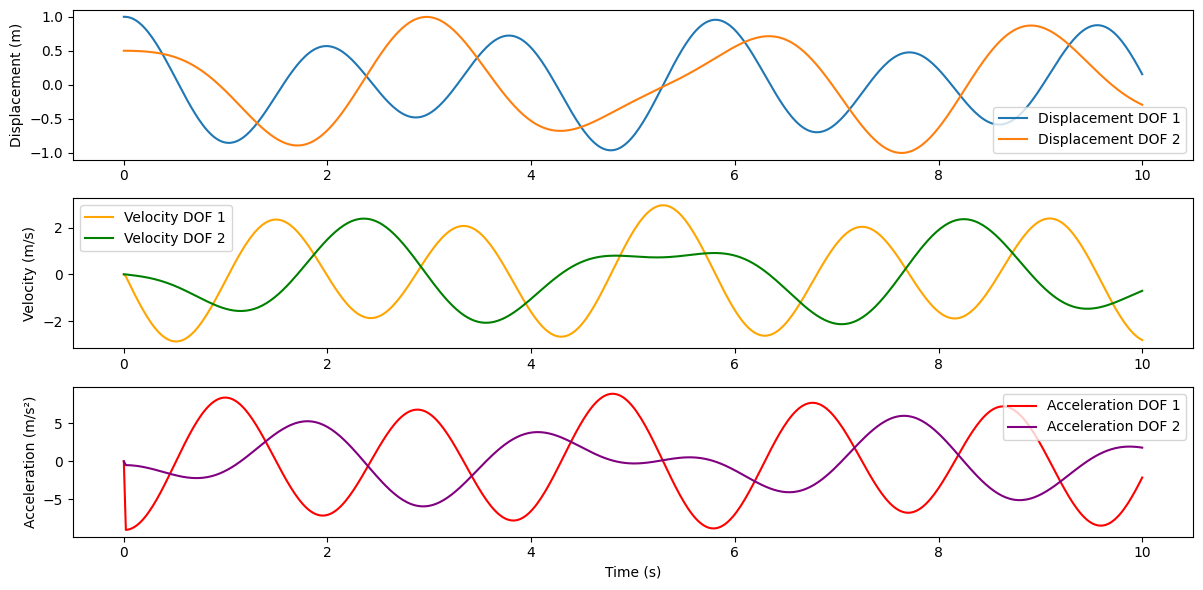

Number of converged steps using Newton-Raphson: 500 / 500
Iterations per time step:
Time step 1: 2 iterations
Time step 2: 2 iterations
Time step 3: 2 iterations
Time step 4: 2 iterations
Time step 5: 2 iterations
Time step 6: 2 iterations
Time step 7: 2 iterations
Time step 8: 2 iterations
Time step 9: 2 iterations
Time step 10: 2 iterations
Time step 11: 2 iterations
Time step 12: 2 iterations
Time step 13: 2 iterations
Time step 14: 2 iterations
Time step 15: 2 iterations
Time step 16: 2 iterations
Time step 17: 2 iterations
Time step 18: 2 iterations
Time step 19: 2 iterations
Time step 20: 2 iterations
Time step 21: 2 iterations
Time step 22: 2 iterations
Time step 23: 2 iterations
Time step 24: 2 iterations
Time step 25: 2 iterations
Time step 26: 2 iterations
Time step 27: 2 iterations
Time step 28: 2 iterations
Time step 29: 2 iterations
Time step 30: 2 iterations
Time step 31: 2 iterations
Time step 32: 2 iterations
Time step 33: 2 iterations
Time step 34: 2 iterations
Time st

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
n_dof = 2  # Number of degrees of freedom

# Mass matrix (M)
M = np.array([[1.0, 0.0], [0.0, 1.0]])  # Mass matrix (2x2 identity matrix for simplicity)

# Stiffness matrix (K)
K = np.array([[10.0, -2.0], [-2.0, 5.0]])  # Stiffness matrix (coupled system)

# No damping
C = np.zeros((n_dof, n_dof))

# Initial external force vector (zero for now)
F0 = np.zeros(n_dof)

# Newmark-beta parameters (Renamed)
beta = 0.25  # Previously alpha
gamma = 0.5  # Previously beta

dt = 0.02  # Time step (s)
t_total = 10  # Total time (s)
time_steps = int(t_total / dt)

t = np.linspace(0, t_total, time_steps + 1)

# Initial conditions
x = np.zeros((time_steps + 1, n_dof))  # Displacement matrix
xdot = np.zeros((time_steps + 1, n_dof))  # Velocity matrix
xddot = np.zeros((time_steps + 1, n_dof))  # Acceleration matrix

# Set initial displacement (Example)
x[0] = np.array([1.0, 0.5])  # Initial displacement vector

# Effective stiffness matrix
K_eff = M / (beta * dt**2) + K

converged_steps = 0
iterations_per_step = []

def force(t):
    return np.zeros(n_dof)  # No external force applied

# Time-stepping loop
for i in range(time_steps):
    # Predictor step (initial guess for Newton-Raphson)
    x_pred = x[i]
    xdot_pred = xdot[i]
    xddot_pred = xddot[i]

    F_ext = force(t[i + 1])

    # Initial guess for displacement (Newton-Raphson)
    x_new = x_pred.copy()
    tol = 1e-6
    max_iter = 100
    num_iterations = 0

    for iteration in range(max_iter):
        num_iterations += 1

        # Compute effective force
        F_eff = F_ext + M @ (x_pred / (beta * dt**2) + xdot_pred / (beta * dt) + (1 / (2 * beta) - 1) * xddot_pred)

        # Compute residual
        R = K_eff @ x_new - F_eff

        # Compute the tangent stiffness (Jacobian)
        K_tangent = K_eff

        # Newton-Raphson update
        delta_x = np.linalg.solve(K_tangent, -R)
        x_new += delta_x

        # Check convergence
        if np.linalg.norm(delta_x) < tol:
            converged_steps += 1
            break

    iterations_per_step.append(num_iterations)

    # Update accelerations and velocities using Newmark formulas
    xddot[i + 1] = (x_new - x[i]) / (beta * dt**2) - xdot[i] / (beta * dt) - ((1 / (2 * beta) - 1) * xddot[i])
    xdot[i + 1] = xdot[i] + dt * ((1 - gamma) * xddot[i] + gamma * xddot[i + 1])
    x[i + 1] = x_new

# Plotting results
plt.figure(figsize=(12, 6))
plt.subplot(3, 1, 1)
plt.plot(t, x[:, 0], label='Displacement DOF 1')
plt.plot(t, x[:, 1], label='Displacement DOF 2')
plt.ylabel('Displacement (m)')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(t, xdot[:, 0], label='Velocity DOF 1', color='orange')
plt.plot(t, xdot[:, 1], label='Velocity DOF 2', color='green')
plt.ylabel('Velocity (m/s)')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(t, xddot[:, 0], label='Acceleration DOF 1', color='red')
plt.plot(t, xddot[:, 1], label='Acceleration DOF 2', color='purple')
plt.ylabel('Acceleration (m/s²)')
plt.legend()
plt.xlabel('Time (s)')

plt.tight_layout()
plt.show()

print(f'Number of converged steps using Newton-Raphson: {converged_steps} / {time_steps}')

# Display the number of iterations for each time step
print('Iterations per time step:')
for i, iters in enumerate(iterations_per_step):
    print(f'Time step {i+1}: {iters} iterations')


In [9]:
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt

def solve_newmark_dynamic_single_case(structural_components, initial_displacement, total_time, dt, 
                                     beta, gamma, tol, max_iter):
    """
    Solve dynamic system for a single case using Newmark-β method

    Args:
        structural_components (dict): Contains system matrices (M, K, F)
        initial_displacement (np.array): Initial displacement vector for this case (1D array)
        total_time (float): Total simulation time
        dt (float): Time step size
        beta (float): Newmark-β parameter
        gamma (float): Newmark-γ parameter
        tol (float): Convergence tolerance
        max_iter (int): Maximum iterations per time step

    Returns:
        dict: Results including displacements, velocities, accelerations, etc.
    """
    # Get system matrices and force vector
    M = structural_components['M_constrained']
    K = structural_components['K_constrained']
    F = structural_components['f_constrained']
    n = M.shape[0]

    # Scale matrices to improve conditioning
    M_scale = 1.0 
    K_scale = 1.0 
    F_scale = 1.0 

    M_scaled = M / M_scale
    K_scaled = K / K_scale
    F_scaled = F / F_scale

    print("\nMatrix scaling factors:")
    print(f"Mass matrix scale: {M_scale:.2e}")
    print(f"Stiffness matrix scale: {K_scale:.2e}")
    print(f"Force vector scale: {F_scale:.2e}")

    # Setup time integration
    n_steps = int(total_time / dt) + 1
    t = np.linspace(0, total_time, n_steps)

    # Initialize solution arrays
    d = np.zeros((n_steps, n))  # Displacement
    v = np.zeros((n_steps, n))  # Velocity
    a = np.zeros((n_steps, n))  # Acceleration

    # Set initial displacement for this case
    d[0] = initial_displacement  # Correctly set the initial displacement

    # Initial acceleration
    a[0] = linalg.solve(M_scaled, F_scaled[0] - K_scaled @ d[0])

    # Newmark constants (pre-calculate for efficiency)
    c1 = 1 / (beta * dt**2)
    c2 = gamma / (beta * dt)
    c3 = 1 / (beta * dt)
    c5 = (1 - 2 * beta) / (2 * beta)

    # Effective stiffness matrix (K_tan^dyn), pre-factor for efficiency
    K_eff = K_scaled + c1 * M_scaled
    K_eff_factor = linalg.lu_factor(K_eff)

    # Convergence tracking arrays
    iterations_per_step = np.zeros(n_steps, dtype=int)
    residuals_per_step = np.zeros(n_steps)
    convergence_status = np.ones(n_steps, dtype=bool)

    # Time stepping
    for i in range(1, n_steps):
        a_pred = a[i-1].copy()  # Initial guess for a_i
        d_pred = d[i - 1] + dt * v[i - 1] + (dt**2) * ((1 - 2 * beta) / 2 * a[i - 1] + beta * a_pred)
        v_pred = v[i - 1] + dt * ((1 - gamma) * a[i - 1] + gamma * a_pred)

        # Newton-Raphson iteration
        d[i] = d_pred.copy()  # Initial guess for displacement at i
        v[i] = v_pred.copy()  # Initial guess for velocity at i
        converged = False

        for j in range(max_iter):
            # Calculate accelerations and velocities based on x_{n+1}
            a_i = c1 * (d[i] - d[i - 1]) - c3 * v[i - 1] - c5 * a[i - 1]
            v_i = c2 * (d[i] - d[i - 1]) - (gamma/beta - 1) * v[i-1] - (dt/2) * (gamma/beta - 2) * a[i - 1]

            # Calculate the residual force
            R = F[i] - M @ a_i - K @ d[i]

            residual_norm = np.linalg.norm(R)

            # Check for Convergence
            if residual_norm < tol:
                converged = True
                iterations_per_step[i] = j + 1
                residuals_per_step[i] = residual_norm
                a[i] = a_i
                v[i] = v_i
                break

            # Solve for the displacement increment (delta_d)
            try:
                delta_d = linalg.lu_solve(K_eff_factor, R)
                d[i] += delta_d
            except np.linalg.LinAlgError:
                break

        if not converged:
            convergence_status[i] = False
            iterations_per_step[i] = max_iter
            residuals_per_step[i] = residual_norm
            a[i] = a_i
            v[i] = v_i
    
    return {
        'time': t,
        'displacement': d,
        'velocity': v,
        'acceleration': a,
        'iterations_per_step': iterations_per_step,
        'residuals_per_step': residuals_per_step,
        'convergence_status': convergence_status,
        'scales': {'M_scale': M_scale, 'K_scale': K_scale, 'F_scale': F_scale}
    }


In [12]:
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt

def solve_newmark_dynamic_single_case(structural_components, initial_displacement, total_time, dt, 
                                     beta, gamma, tol, max_iter):
    """
    Solve dynamic system for a single case using Newmark-β method

    Args:
        structural_components (dict): Contains system matrices (M, K, F)
        initial_displacement (np.array): Initial displacement vector for this case (1D array)
        total_time (float): Total simulation time
        dt (float): Time step size
        beta (float): Newmark-β parameter
        gamma (float): Newmark-γ parameter
        tol (float): Convergence tolerance
        max_iter (int): Maximum iterations per time step

    Returns:
        dict: Results including displacements, velocities, accelerations, etc.
    """
    # Get system matrices and force vector
    M = structural_components['M_constrained']
    K = structural_components['K_constrained']
    F = structural_components['f_constrained']
    n = M.shape[0]

    # Scale matrices to improve conditioning
    M_scale = 1.0 
    K_scale = 1.0 
    F_scale = 1.0 

    M_scaled = M / M_scale
    K_scaled = K / K_scale
    F_scaled = F / F_scale

    print("\nMatrix scaling factors:")
    print(f"Mass matrix scale: {M_scale:.2e}")
    print(f"Stiffness matrix scale: {K_scale:.2e}")
    print(f"Force vector scale: {F_scale:.2e}")

    # Setup time integration
    n_steps = int(total_time / dt) + 1
    t = np.linspace(0, total_time, n_steps)

    # Initialize solution arrays
    d = np.zeros((n_steps, n))  # Displacement
    v = np.zeros((n_steps, n))  # Velocity
    a = np.zeros((n_steps, n))  # Acceleration

    # Set initial displacement for this case
    d[0] = initial_displacement  # Correctly set the initial displacement

    # Initial acceleration
    a[0] = linalg.solve(M_scaled, F_scaled[0] - K_scaled @ d[0])

    # Newmark constants (pre-calculate for efficiency)
    c1 = 1 / (beta * dt**2)
    c2 = gamma / (beta * dt)
    c3 = 1 / (beta * dt)
    c5 = (1 - 2 * beta) / (2 * beta)

    # Effective stiffness matrix (K_tan^dyn), pre-factor for efficiency
    K_eff = K_scaled + c1 * M_scaled
    K_eff_factor = linalg.lu_factor(K_eff)

    # Convergence tracking arrays
    iterations_per_step = np.zeros(n_steps, dtype=int)
    residuals_per_step = np.zeros(n_steps)
    convergence_status = np.ones(n_steps, dtype=bool)

    # Count of converged steps
    converged_steps_count = 0

    # Time stepping
    for i in range(1, n_steps):
        a_pred = a[i-1].copy()  # Initial guess for a_i
        d_pred = d[i - 1] + dt * v[i - 1] + (dt**2) * ((1 - 2 * beta) / 2 * a[i - 1] + beta * a_pred)
        v_pred = v[i - 1] + dt * ((1 - gamma) * a[i - 1] + gamma * a_pred)

        # Newton-Raphson iteration
        d[i] = d_pred.copy()  # Initial guess for displacement at i
        v[i] = v_pred.copy()  # Initial guess for velocity at i
        converged = False

        for j in range(max_iter):
            # Calculate accelerations and velocities based on x_{n+1}
            a_i = c1 * (d[i] - d[i - 1]) - c3 * v[i - 1] - c5 * a[i - 1]
            v_i = c2 * (d[i] - d[i - 1]) - (gamma/beta - 1) * v[i-1] - (dt/2) * (gamma/beta - 2) * a[i - 1]

            # Calculate the residual force
            R = F[i] - M @ a_i - K @ d[i]

            residual_norm = np.linalg.norm(R)

            # Check for Convergence
            if residual_norm < tol:
                converged = True
                iterations_per_step[i] = j + 1
                residuals_per_step[i] = residual_norm
                a[i] = a_i
                v[i] = v_i
                converged_steps_count += 1
                break

            # Solve for the displacement increment (delta_d)
            try:
                delta_d = linalg.lu_solve(K_eff_factor, R)
                d[i] += delta_d
            except np.linalg.LinAlgError:
                break

        if not converged:
            convergence_status[i] = False
            iterations_per_step[i] = max_iter
            residuals_per_step[i] = residual_norm
            a[i] = a_i
            v[i] = v_i
    
    print(f"\nNumber of converged steps: {converged_steps_count} out of {n_steps}")
    print("\nNumber of iterations per step:")
    for step, iters in enumerate(iterations_per_step):
        print(f"Time step {step + 1}: {iters} iterations")

    return {
        'time': t,
        'displacement': d,
        'velocity': v,
        'acceleration': a,
        'iterations_per_step': iterations_per_step,
        'residuals_per_step': residuals_per_step,
        'convergence_status': convergence_status,
        'scales': {'M_scale': M_scale, 'K_scale': K_scale, 'F_scale': F_scale}
    }



Matrix scaling factors:
Mass matrix scale: 1.00e+00
Stiffness matrix scale: 1.00e+00
Force vector scale: 1.00e+00

Number of converged steps: 5000 out of 5001

Number of iterations per step:
Time step 1: 0 iterations
Time step 2: 2 iterations
Time step 3: 2 iterations
Time step 4: 2 iterations
Time step 5: 2 iterations
Time step 6: 2 iterations
Time step 7: 2 iterations
Time step 8: 2 iterations
Time step 9: 2 iterations
Time step 10: 2 iterations
Time step 11: 2 iterations
Time step 12: 2 iterations
Time step 13: 2 iterations
Time step 14: 2 iterations
Time step 15: 2 iterations
Time step 16: 2 iterations
Time step 17: 2 iterations
Time step 18: 2 iterations
Time step 19: 2 iterations
Time step 20: 2 iterations
Time step 21: 2 iterations
Time step 22: 2 iterations
Time step 23: 2 iterations
Time step 24: 2 iterations
Time step 25: 2 iterations
Time step 26: 2 iterations
Time step 27: 2 iterations
Time step 28: 2 iterations
Time step 29: 2 iterations
Time step 30: 2 iterations
Time st

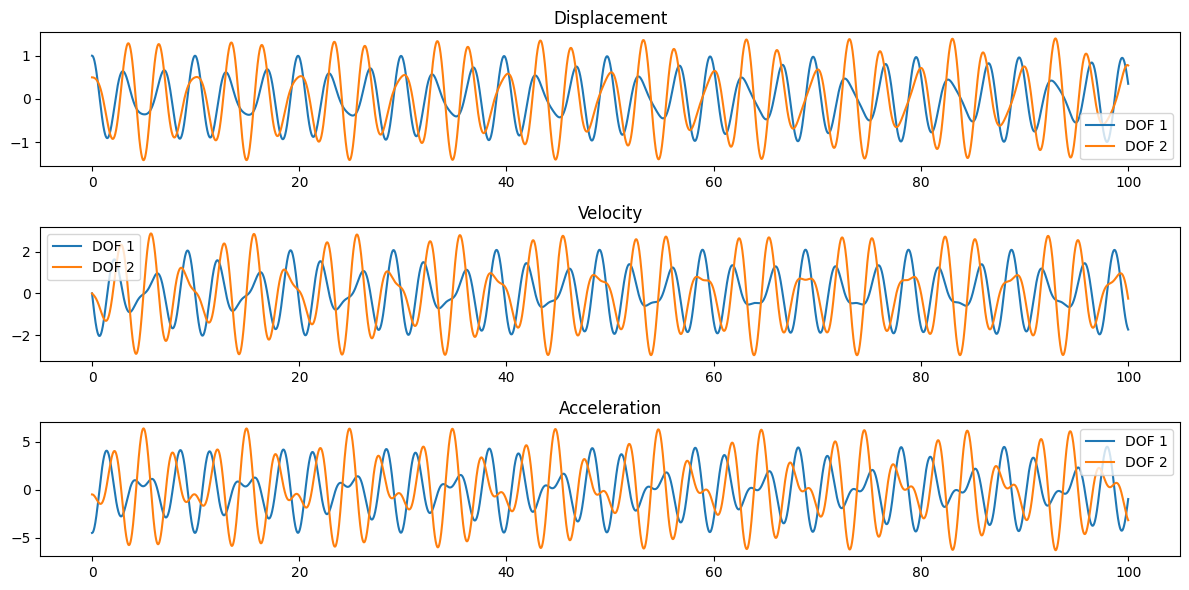

In [24]:
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt

# Define system matrices
M = np.array([[2.0, 0.0], [0.0, 1.0]])  # Mass matrix
K = np.array([[10.0, -2.0], [-2.0, 5.0]])  # Stiffness matrix

# Define force vector for each time step (zero force in this case)
total_time = 100.0
dt = 0.02
n_steps = int(total_time / dt) + 1
F = np.zeros((n_steps, 2))  # Two DOFs, force applied is zero

# Initial conditions
initial_displacement = np.array([1.0, 0.5])

# Define structural components dictionary
structural_components = {
    'M_constrained': M,
    'K_constrained': K,
    'f_constrained': F
}

# Newmark parameters
beta = 0.25
gamma = 0.5
tol = 1e-6
max_iter = 100

# Run the solver
results = solve_newmark_dynamic_single_case(structural_components, initial_displacement, total_time, dt,
                                            beta, gamma, tol, max_iter)

# Plotting results
time = results['time']
displacement = results['displacement']
velocity = results['velocity']
acceleration = results['acceleration']

plt.figure(figsize=(12, 6))

# Plot Displacement for each DOF
plt.subplot(3, 1, 1)
plt.plot(time, displacement[:, 0], label='DOF 1')
plt.plot(time, displacement[:, 1], label='DOF 2')
plt.title('Displacement')
plt.legend()

# Plot Velocity for each DOF
plt.subplot(3, 1, 2)
plt.plot(time, velocity[:, 0], label='DOF 1')
plt.plot(time, velocity[:, 1], label='DOF 2')
plt.title('Velocity')
plt.legend()

# Plot Acceleration for each DOF
plt.subplot(3, 1, 3)
plt.plot(time, acceleration[:, 0], label='DOF 1')
plt.plot(time, acceleration[:, 1], label='DOF 2')
plt.title('Acceleration')
plt.legend()

plt.tight_layout()

# Print maximum values
print(f"Maximum displacement: {np.max(displacement, axis=0)}")
print(f"Maximum velocity: {np.max(velocity, axis=0)}")
print(f"Maximum acceleration: {np.max(acceleration, axis=0)}")
plt.show()


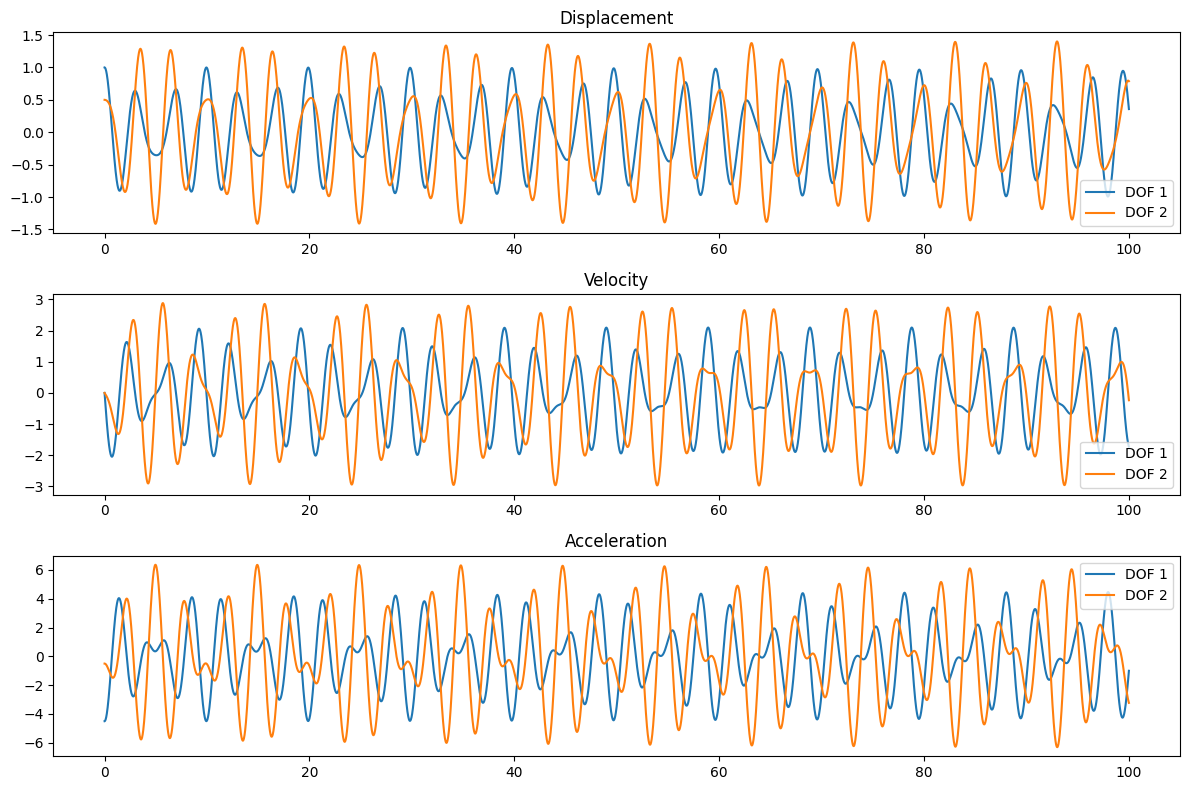

Maximum Displacement for DOF 1: 1.0
Maximum Displacement for DOF 2: 1.41371324542593
Maximum Velocity for DOF 1: 2.099858487301974
Maximum Velocity for DOF 2: 2.9698920287254014
Maximum Acceleration for DOF 1: 4.5
Maximum Acceleration for DOF 2: 6.362125731089774


In [22]:
# MDOF System Solver using State-Space Approach

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint


def mdof_system_dynamics(y, t, M, K, F):
    """
    Defines the equations of motion for an MDOF system using state-space representation.

    Args:
        y (np.array): State vector containing displacement and velocity [x, x_dot].
        t (float): Current time step.
        M (np.array): Mass matrix.
        K (np.array): Stiffness matrix.
        F (np.array): External force vector at each time step.

    Returns:
        np.array: Derivative of the state vector.
    """
    n = M.shape[0]
    x = y[:n]
    x_dot = y[n:]

    # External forces (assuming time-varying forces)
    F_t = F

    # Compute acceleration
    x_ddot = np.linalg.solve(M, F_t - K @ x)

    # Return the derivative of the state vector
    return np.concatenate((x_dot, x_ddot))


def solve_mdof(M, K, F, initial_displacement, initial_velocity, total_time, dt):
    """
    Solves the MDOF dynamic system using the state-space approach.

    Args:
        M (np.array): Mass matrix.
        K (np.array): Stiffness matrix.
        F (np.array): External force vector (same for all time steps).
        initial_displacement (np.array): Initial displacement vector.
        initial_velocity (np.array): Initial velocity vector.
        total_time (float): Total simulation time.
        dt (float): Time step size.

    Returns:
        np.array, np.array: Time vector and solution matrix.
    """
    n = M.shape[0]
    y0 = np.concatenate((initial_displacement, initial_velocity))

    # Time vector
    time = np.arange(0, total_time, dt)

    # Solve using odeint
    sol = odeint(mdof_system_dynamics, y0, time, args=(M, K, F))

    # Extract displacement, velocity, and acceleration
    displacement = sol[:, :n]
    velocity = sol[:, n:]

    # Calculate acceleration at each time step
    acceleration = np.array([np.linalg.solve(M, F - K @ displacement[i, :]) for i in range(len(time))])

    return time, displacement, velocity, acceleration


# Example Usage
M = np.array([[2.0, 0.0], [0.0, 1.0]])  # Mass matrix
K = np.array([[10.0, -2.0], [-2.0, 5.0]])  # Stiffness matrix

# Define force vector for each time step (zero force in this case)
total_time = 100.0
dt = 0.02
n_steps = int(total_time / dt) + 1
F = np.zeros(2)  # Two DOFs, force applied is zero

initial_displacement = np.array([1.0, 0.5])
initial_velocity = np.array([0.0, 0.0])

# Solving the MDOF system
time, displacement, velocity, acceleration = solve_mdof(M, K, F, initial_displacement, initial_velocity, total_time, dt)

# Plotting the results
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(time, displacement[:, 0], label='DOF 1')
plt.plot(time, displacement[:, 1], label='DOF 2')
plt.title('Displacement')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(time, velocity[:, 0], label='DOF 1')
plt.plot(time, velocity[:, 1], label='DOF 2')
plt.title('Velocity')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(time, acceleration[:, 0], label='DOF 1')
plt.plot(time, acceleration[:, 1], label='DOF 2')
plt.title('Acceleration')
plt.legend()

plt.tight_layout()
plt.show()

# Print maximum values
print('Maximum Displacement for DOF 1:', np.max(np.abs(displacement[:, 0])))
print('Maximum Displacement for DOF 2:', np.max(np.abs(displacement[:, 1])))
print('Maximum Velocity for DOF 1:', np.max(np.abs(velocity[:, 0])))
print('Maximum Velocity for DOF 2:', np.max(np.abs(velocity[:, 1])))
print('Maximum Acceleration for DOF 1:', np.max(np.abs(acceleration[:, 0])))
print('Maximum Acceleration for DOF 2:', np.max(np.abs(acceleration[:, 1])))


In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Define the values for a 2x2 system
M_constrained = np.array([[1000, 0], [0, 1000]])  # Mass matrix (kg)
K_constrained = np.array([[1e11, 0], [0, 1e11]])  # Stiffness matrix (N/m)
f_constrained = np.array([[9810], [9810]])       # Force vector (N)

# Time step and total simulation time
dt = 3.14e-6               # Time step = T/200
total_time = 0.01          # Total simulation time

magnitudes = ((1.0, 2.0, 3.0),)

n_dof = M_constrained.shape[0]  # Number of degrees of freedom
x0 = np.zeros((1,n_dof)) # Displacement (m) as a 1x1 matrix
print(f"Initial displacement shape: {x0.shape}")
print(x0)

Initial displacement shape: (1, 2)
[[0. 0.]]


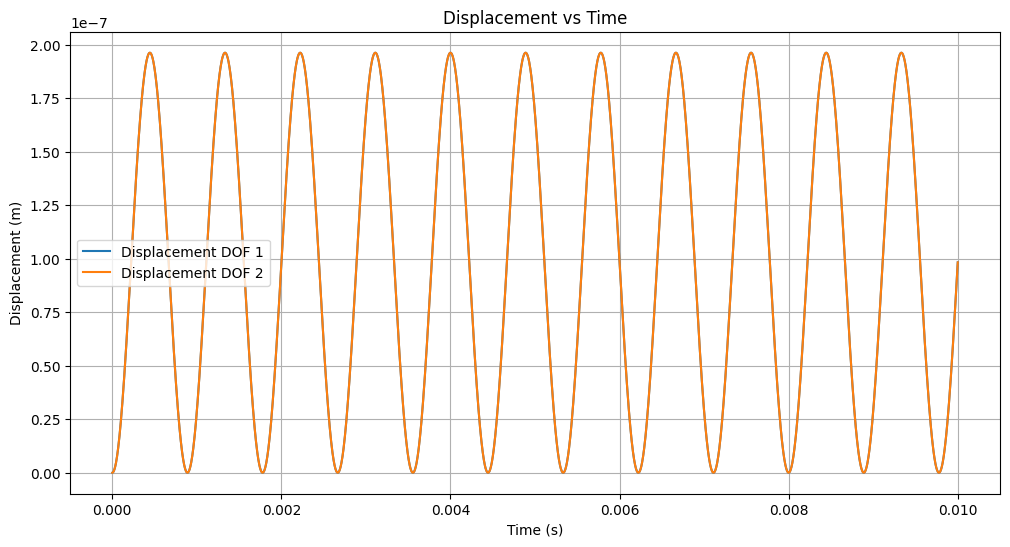

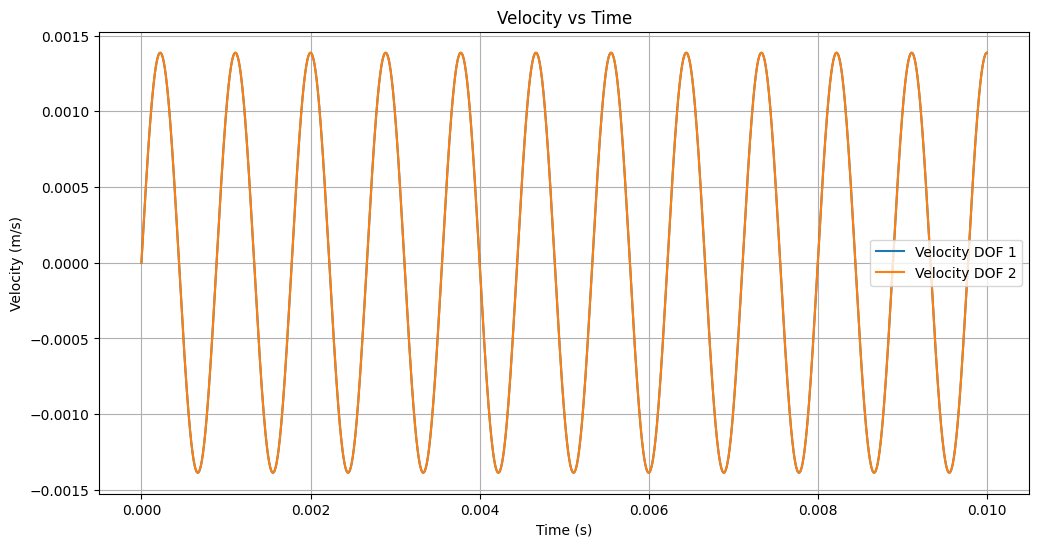

Max Displacement: 1.961972e-07 m
Max Velocity: 1.387427e-03 m/s
Max Acceleration: 9.810000e+00 m/s²


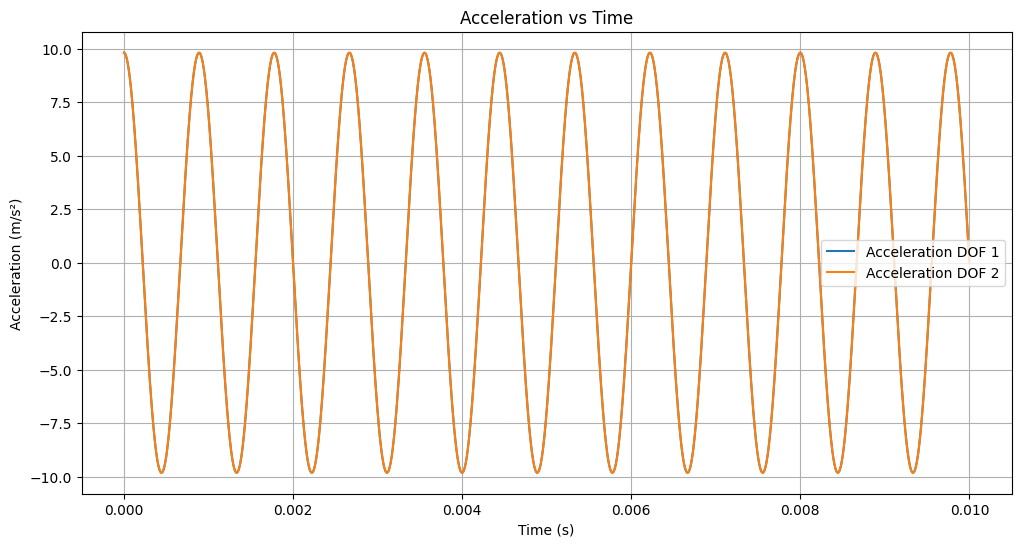

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
import time
from tqdm import tqdm

def solve_newmark_dynamic_single_case(structural_components, initial_displacement, total_time, dt, 
                                      beta, gamma, tol, max_iter):
    M = structural_components['M_constrained']
    K = structural_components['K_constrained']
    F = structural_components['f_constrained']
    n = M.shape[0]

    n_steps = int(total_time / dt) + 1
    t = np.linspace(0, total_time, n_steps)

    d = np.zeros((n_steps, n))
    v = np.zeros((n_steps, n))
    a = np.zeros((n_steps, n))

    d[0] = initial_displacement
    a[0] = linalg.solve(M, F - K @ d[0])

    c1 = 1 / (beta * dt**2)
    c2 = gamma / (beta * dt)
    K_eff = K + c1 * M
    K_eff_factor = linalg.lu_factor(K_eff)

    for i in range(1, n_steps):
        d_pred = d[i - 1] + dt * v[i - 1] + (dt**2) * ((1 - 2 * beta) / 2 * a[i - 1])
        v_pred = v[i - 1] + dt * (1 - gamma) * a[i - 1]

        for j in range(max_iter):
            a_i = c1 * (d_pred - d[i - 1]) - c2 * v[i - 1]
            R = F - M @ a_i - K @ d_pred

            residual_norm = np.linalg.norm(R)

            if residual_norm < tol:
                break

            delta_d = linalg.lu_solve(K_eff_factor, R)
            d_pred += delta_d

        d[i] = d_pred
        a[i] = a_i
        v[i] = v_pred + gamma * dt * a[i]

    return {
        'time': t,
        'displacement': d,
        'velocity': v,
        'acceleration': a,
    }


if __name__ == "__main__":
    # Define the values for a 2x2 system
    M_constrained = np.array([[1000, 0], [0, 1000]])  # Mass matrix (kg)
    K_constrained = np.array([[1e11, 0], [0, 1e11]])  # Stiffness matrix (N/m)
    f_constrained = np.array([[9810], [9810]])       # Force vector (N)

    # Time step and total simulation time
    dt = 3.14e-6               # Time step = T/200
    total_time = 0.01          # Total simulation time

    n_dof = M_constrained.shape[0]  # Number of degrees of freedom
    x0 = np.zeros(n_dof)  # Initial displacement (m) as a 1D array

    structural_components = {
        'M_constrained': M_constrained,
        'K_constrained': K_constrained,
        'f_constrained': f_constrained.flatten()
    }

    # Parameters for Newmark-beta method
    beta = 0.25
    gamma = 0.5
    tol = 1e-8
    max_iter = 50

    # Solving the problem
    results = solve_newmark_dynamic_single_case(
        structural_components=structural_components,
        initial_displacement=x0,
        total_time=total_time,
        dt=dt,
        beta=beta,
        gamma=gamma,
        tol=tol,
        max_iter=max_iter
    )

    # Extract results
    time = results['time']
    displacement = results['displacement']
    velocity = results['velocity']
    acceleration = results['acceleration']

    # Plotting Displacement
    plt.figure(figsize=(12, 6))
    plt.plot(time, displacement[:, 0], label='Displacement DOF 1')
    plt.plot(time, displacement[:, 1], label='Displacement DOF 2')
    plt.title('Displacement vs Time')
    plt.xlabel('Time (s)')
    plt.ylabel('Displacement (m)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plotting Velocity
    plt.figure(figsize=(12, 6))
    plt.plot(time, velocity[:, 0], label='Velocity DOF 1')
    plt.plot(time, velocity[:, 1], label='Velocity DOF 2')
    plt.title('Velocity vs Time')
    plt.xlabel('Time (s)')
    plt.ylabel('Velocity (m/s)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plotting Acceleration
    plt.figure(figsize=(12, 6))
    plt.plot(time, acceleration[:, 0], label='Acceleration DOF 1')
    plt.plot(time, acceleration[:, 1], label='Acceleration DOF 2')
    print(f"Max Displacement: {np.max(np.abs(displacement)):.6e} m")
    print(f"Max Velocity: {np.max(np.abs(velocity)):.6e} m/s")
    print(f"Max Acceleration: {np.max(np.abs(acceleration)):.6e} m/s²")
    plt.title('Acceleration vs Time')
    plt.xlabel('Time (s)')
    plt.ylabel('Acceleration (m/s²)')
    plt.legend()
    plt.grid(True)
    plt.show()


(2, 3185)


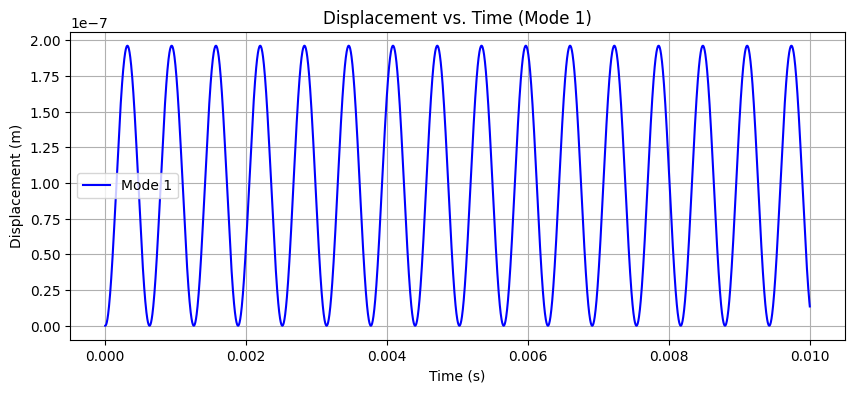

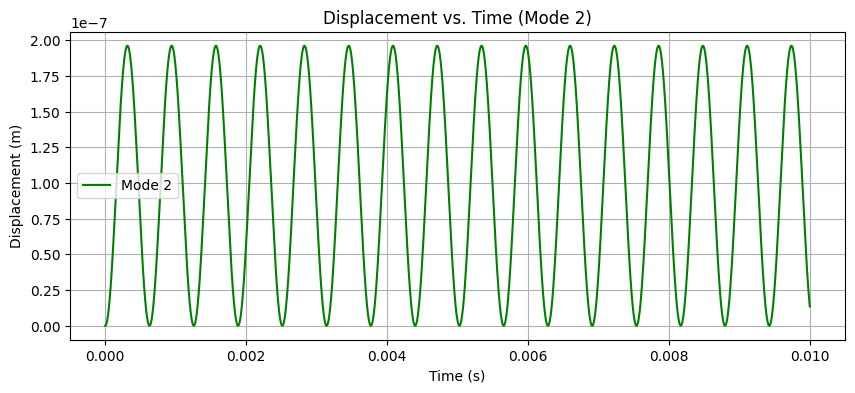

Mode 1:
  Maximum displacement: 1.9619996122289573e-07
  Maximum velocity: 0.0009809999030572344
  Maximum acceleration: 9.81
Mode 2:
  Maximum displacement: 1.9619996122289573e-07
  Maximum velocity: 0.0009809999030572344
  Maximum acceleration: 9.81

Maximum displacement considering both modes: 3.9239992244579146e-07
1.9619996122289573e-07


In [16]:
# Calculate number of steps
n_steps = int(total_time / dt) + 1

# Time array
t = np.linspace(0, total_time, n_steps)

# Analytical solution for displacement
omega = np.sqrt(np.linalg.inv(M_constrained) @ K_constrained)  # Natural frequency matrix
x_analytical = np.zeros((M_constrained.shape[0], n_steps))  # Initialize displacement array

for i in range(M_constrained.shape[0]):
    x_analytical[i, :] = (f_constrained[i] / K_constrained[i, i]) * (1 - np.cos(omega[i, i] * t))

print(x_analytical.shape)

# Calculate velocity and acceleration
v_analytical = np.zeros_like(x_analytical)
a_analytical = np.zeros_like(x_analytical)

for i in range(M_constrained.shape[0]):
    v_analytical[i, :] = (f_constrained[i] / K_constrained[i, i]) * omega[i, i] * np.sin(omega[i, i] * t)
    a_analytical[i, :] = (f_constrained[i] / K_constrained[i, i]) * omega[i, i]**2 * np.cos(omega[i, i] * t)

# Plot the results for each mode separately with different colors
colors = ['b', 'g']  # Define colors for each mode
for i in range(M_constrained.shape[0]):
    plt.figure(figsize=(10, 4))
    plt.plot(t, x_analytical[i, :], color=colors[i % len(colors)], label=f'Mode {i+1}')
    plt.xlabel('Time (s)')
    plt.ylabel('Displacement (m)')
    plt.title(f'Displacement vs. Time (Mode {i+1})')
    plt.grid(True)
    plt.legend()
    plt.show()

# Print maximum values for each mode
for i in range(M_constrained.shape[0]):
    print(f"Mode {i+1}:")
    print(f"  Maximum displacement: {max(x_analytical[i, :])}")
    print(f"  Maximum velocity: {max(v_analytical[i, :])}")
    print(f"  Maximum acceleration: {max(a_analytical[i, :])}")

# Print maximum displacement considering both modes
max_displacement_combined = np.max(np.sum(x_analytical, axis=0))
print(f"\nMaximum displacement considering both modes: {max_displacement_combined}")
print(np.max(np.abs(x_analytical)))

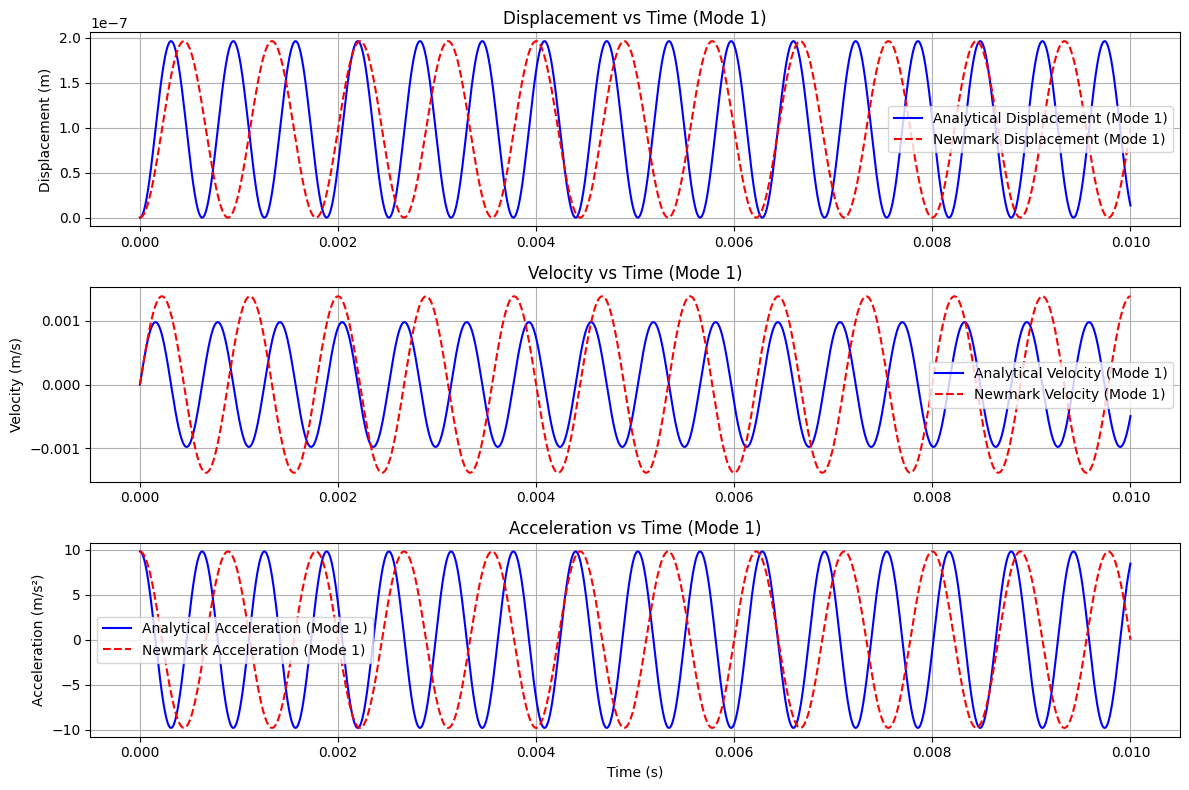

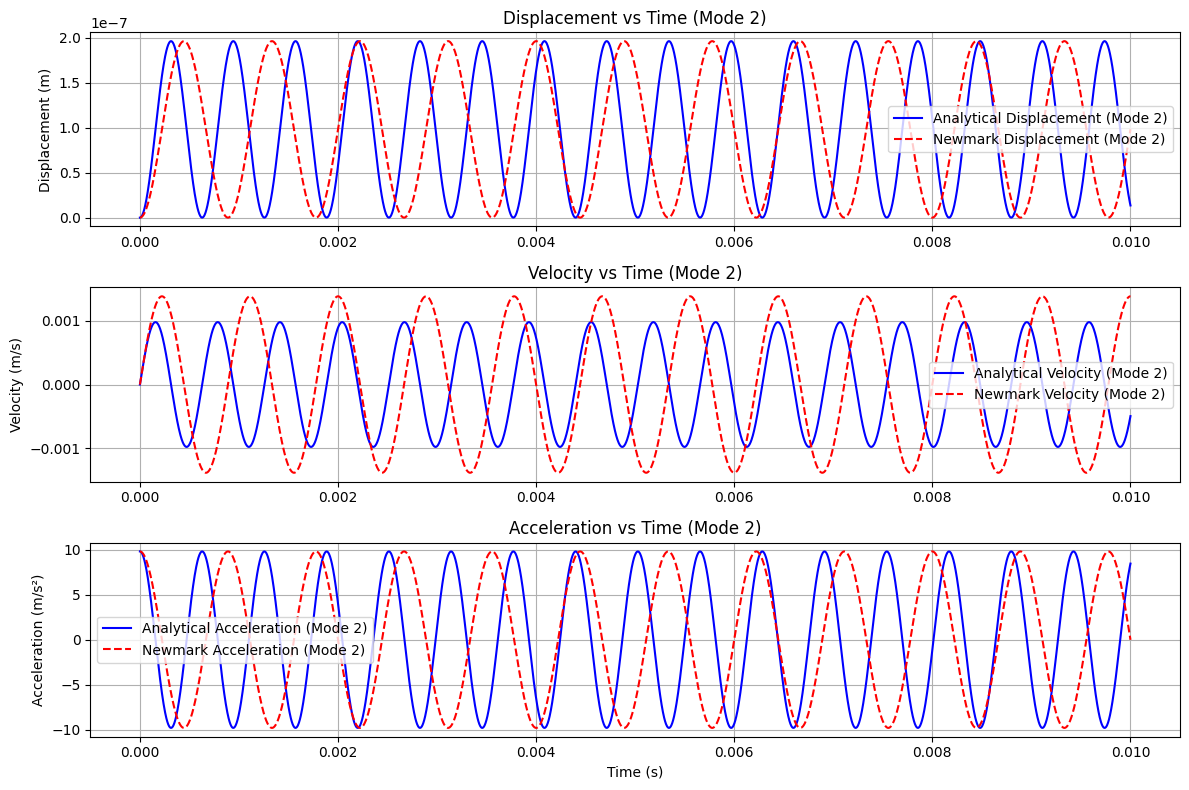

In [17]:
# Superimpose plots for displacement, velocity, and acceleration
for mode in range(n_dof):
    plt.figure(figsize=(12, 8))

    # Displacement plot
    plt.subplot(3, 1, 1)
    plt.plot(t, x_analytical[mode, :], label=f'Analytical Displacement (Mode {mode + 1})', color='b')
    plt.plot(t, displacement[:, mode], label=f'Newmark Displacement (Mode {mode + 1})', color='r', linestyle='--')
    plt.ylabel('Displacement (m)')
    plt.title(f'Displacement vs Time (Mode {mode + 1})')
    plt.grid(True)
    plt.legend()

    # Velocity plot
    plt.subplot(3, 1, 2)
    plt.plot(t, v_analytical[mode, :], label=f'Analytical Velocity (Mode {mode + 1})', color='b')
    plt.plot(t, velocity[:, mode], label=f'Newmark Velocity (Mode {mode + 1})', color='r', linestyle='--')
    plt.ylabel('Velocity (m/s)')
    plt.title(f'Velocity vs Time (Mode {mode + 1})')
    plt.grid(True)
    plt.legend()

    # Acceleration plot
    plt.subplot(3, 1, 3)
    plt.plot(t, a_analytical[mode, :], label=f'Analytical Acceleration (Mode {mode + 1})', color='b')
    plt.plot(t, acceleration[:, mode], label=f'Newmark Acceleration (Mode {mode + 1})', color='r', linestyle='--')
    plt.xlabel('Time (s)')
    plt.ylabel('Acceleration (m/s²)')
    plt.title(f'Acceleration vs Time (Mode {mode + 1})')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

In [34]:
import numpy as np
import matplotlib.pyplot as plt

# Define the values
M_constrained = np.array([[1000]])  # Mass (kg)
K_constrained = np.array([[1e5]])  # Spring constant (N/m)
f_constrained = np.array([[9810]])  # Force (N)
# f_constrained = f_constrained.flatten()  # Flatten to 1D array

dt = 0.005               # Time step = T/200
total_time = 10          # Total simulation time

# Calculate number of steps
n_steps = int(total_time / dt)+1

x = np.zeros(1)  # Initial displacement (m) as a 1D array
print(f_constrained.flatten().shape)

magnitudes = ((1.0, 2.0, 3.0),)

(1,)


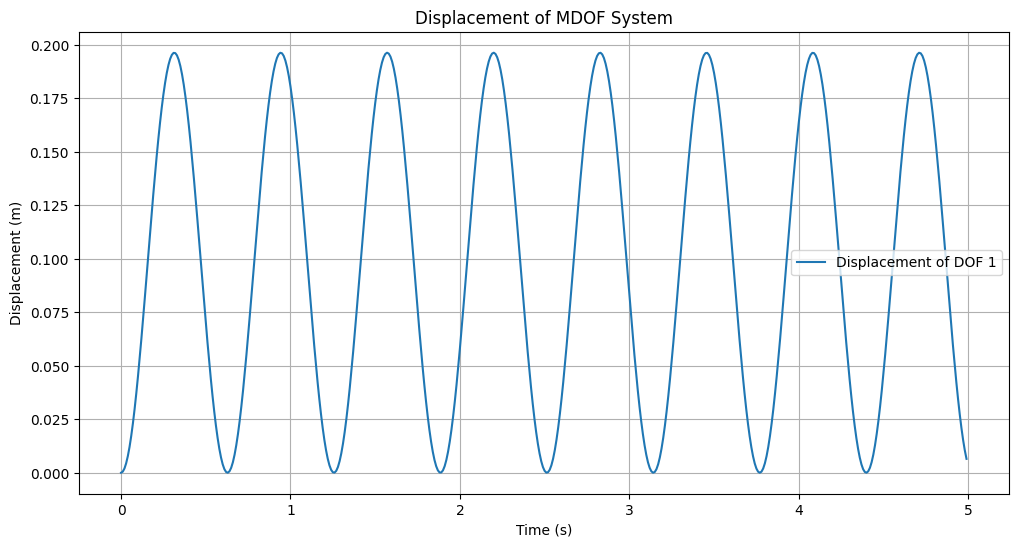

Maximum displacement: 1.961969e-01 m
Maximum velocity: 9.809938e-01 m/s
Maximum acceleration: 9.805910e+00 m/s²


In [ ]:
# MDOF System Solver using State-Space Approach

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint


def mdof_system_dynamics(y, t, M, K, F, w_f):
    """
    Defines the equations of motion for an MDOF system using state-space representation.

    Args:
        y (np.array): State vector containing displacement and velocity [x, x_dot].
        t (float): Current time step.
        M (np.array): Mass matrix.
        K (np.array): Stiffness matrix.
        F (np.array): External force vector.
        w_f (np.array): Frequency of applied forces.

    Returns:
        np.array: Derivative of the state vector.
    """
    n = M.shape[0]
    x = y[:n]
    x_dot = y[n:]

    # External forces (assuming harmonic forces)
    F_t = F #* np.sin(2 * np.pi * w_f * t)

    # Compute acceleration
    # x_ddot = np.linalg.solve(M, F_t - K @ x)
    x_ddot = np.linalg.solve(M, F_t - K @ x).flatten()  # Convert to 1D array


    # Return the derivative of the state vector
    return np.concatenate((x_dot, x_ddot))


def solve_mdof(M, K, F, w_f, initial_displacement, initial_velocity, total_time, dt):
    """
    Solves the MDOF dynamic system using the state-space approach.

    Args:
        M (np.array): Mass matrix.
        K (np.array): Stiffness matrix.
        F (np.array): External force vector (constant for all DOFs).
        w_f (np.array): Frequencies of the applied forces.
        initial_displacement (np.array): Initial displacement vector.
        initial_velocity (np.array): Initial velocity vector.
        total_time (float): Total simulation time.
        dt (float): Time step size.

    Returns:
        np.array, np.array: Time vector and solution matrix.
    """
    n = M.shape[0]
    y0 = np.concatenate((initial_displacement, initial_velocity))

    # Time vector
    time = np.arange(0, total_time, dt)

    # Solve using odeint
    sol = odeint(mdof_system_dynamics, y0, time, args=(M, K, F, w_f))

    # Extract displacement and velocity
    displacement = sol[:, :n]
    velocity = sol[:, n:]

    return time, displacement, velocity


# Example Usage
# M = np.array([[1, 0], [0, 2]])  # Mass matrix
# K = np.array([[6000, -2000], [-2000, 8000]])  # Stiffness matrix
# F = np.array([20, 0])  # External force applied only to first DOF
w_f = np.array([0])  # Frequency of applied forces

M = np.array([[1000]])  # Mass matrix (kg)
K = np.array([[1e5]])  # Stiffness matrix (N/m)
F = np.array([[9810]])  # Force vector (N)

initial_displacement = np.array([0])
initial_velocity = np.array([0])
total_time = 5

dt = 0.01  # Time step size

# Solving the MDOF system

time, displacement, velocity = solve_mdof(M, K, F, w_f, initial_displacement, initial_velocity, total_time, dt)

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(time, displacement[:, 0], label='Displacement of DOF 1')
# plt.plot(time, displacement[:, 1], label='Displacement of DOF 2')
plt.xlabel('Time (s)')
plt.ylabel('Displacement (m)')
plt.title('Displacement of MDOF System')
plt.legend()
plt.grid(True)
plt.show()

print(f"Maximum displacement: {np.max(displacement[:, 0]):.6e} m")
print(f"Maximum velocity: {np.max(velocity[:, 0]):.6e} m/s")
print(f"Maximum acceleration: {np.max(np.diff(velocity[:, 0]) / dt):.6e} m/s²")

In [ ]:
# MDOF System Solver using State-Space Approach (Using MATLAB Logic)

import numpy as np
from scipy.integrate import solve_ivp
import time
from tqdm import tqdm
from pathlib import Path
from tabulate import tabulate


def mdof_system_dynamics(t, y, A, B):
    return A @ y + B.flatten()


def solve_mdof(M, K, f, magnitudes, x, total_time, dt):
    n_dof = M.shape[0]
    num_cases = f.shape[1]
    time_steps = np.arange(0, total_time, dt)
    t_span = (0, total_time)

    M_inv = np.linalg.inv(M)

    results = []
    case_times = []

    for case in tqdm(range(num_cases), desc="Solving cases"):
        F = f[:, case]  # Extract force vector for the current case
        initial_displacement = x[:, case]  # Extract initial displacement for the current case
        initial_velocity = np.zeros(n_dof)

        # Ensure y0 is of size 2*n_dof
        y0 = np.concatenate([initial_displacement.flatten(), initial_velocity.flatten()])

        # Define system matrix A and input matrix B (Based on MATLAB logic)
        A = np.block([
            [np.zeros((n_dof, n_dof)), np.eye(n_dof)],
            [-M_inv @ K, np.zeros((n_dof, n_dof))]
        ])

        F_case = M_inv @ F.reshape(-1, 1)  # Ensure force is a column vector
        B = np.vstack([np.zeros((n_dof, 1)), F_case])  # B must have size (2*n_dof, 1)

        case_start_time = time.time()

        # Solving using solve_ivp
        sol = solve_ivp(mdof_system_dynamics, t_span, y0, t_eval=time_steps, args=(A, B), method='RK45')

        U = sol.y
        displacement = U[:n_dof, :]
        velocity = U[n_dof:, :]

        # Compute acceleration at each time step
        acceleration = np.array([np.linalg.solve(M, F - K @ displacement[:, i]) for i in range(len(time_steps))])

        case_time = time.time() - case_start_time
        case_times.append(case_time)

        results.append({
            "case": case + 1,
            "magnitude": magnitudes[case],
            "max_displacement": np.max(np.abs(displacement)),
            "max_velocity": np.max(np.abs(velocity)),
            "max_acceleration": np.max(np.abs(acceleration)),
            "solve_time": case_time
        })

    return results, case_times


# Example Usage
# Matrices M, K, f, x, and magnitudes are already defined externally.


Solving cases: 100%|██████████| 1/1 [00:00<00:00, 54.54it/s]



Results Summary:
+--------+-------------+--------------------+----------------+--------------------+------------------+
|   Case |   Magnitude |   Max Displacement |   Max Velocity |   Max Acceleration |   Solve Time (s) |
+========+=============+====================+================+====================+==================+
|      1 |           1 |              0.196 |          0.981 |               9.81 |             0.02 |
+--------+-------------+--------------------+----------------+--------------------+------------------+


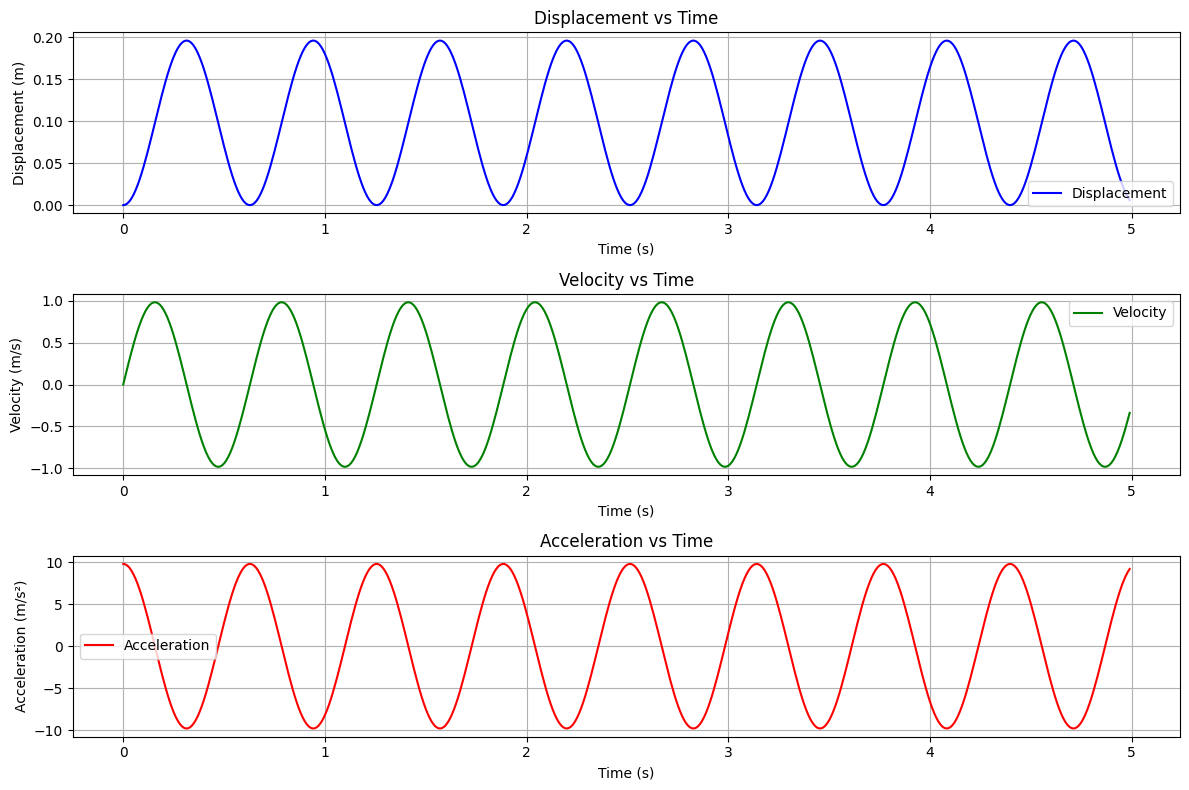

In [3]:
# MDOF System Solver using State-Space Approach (Using MATLAB Logic)

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import time
from tqdm import tqdm
from tabulate import tabulate


def mdof_system_dynamics(t, y, A, B):
    return A @ y + B.flatten()


def solve_mdof(M, K, f, magnitudes, x, total_time, dt):
    n_dof = M.shape[0]
    num_cases = f.shape[1]
    time_steps = np.arange(0, total_time, dt)
    t_span = (0, total_time)

    M_inv = np.linalg.inv(M)

    results = []
    case_times = []

    for case in tqdm(range(num_cases), desc="Solving cases"):
        F = f[:, case]  # Extract force vector for the current case
        initial_displacement = x[:, case]  # Extract initial displacement for the current case
        initial_velocity = np.zeros(n_dof)

        # Ensure y0 is of size 2*n_dof
        y0 = np.concatenate([initial_displacement.flatten(), initial_velocity.flatten()])

        # Define system matrix A and input matrix B (Based on MATLAB logic)
        A = np.block([
            [np.zeros((n_dof, n_dof)), np.eye(n_dof)],
            [-M_inv @ K, np.zeros((n_dof, n_dof))]
        ])

        F_case = M_inv @ F.reshape(-1, 1)  # Ensure force is a column vector
        B = np.vstack([np.zeros((n_dof, 1)), F_case])  # B must have size (2*n_dof, 1)

        case_start_time = time.time()

        # Solving using solve_ivp
        sol = solve_ivp(mdof_system_dynamics, t_span, y0, t_eval=time_steps, args=(A, B), method='RK45')

        U = sol.y
        displacement = U[:n_dof, :]
        velocity = U[n_dof:, :]

        # Compute acceleration at each time step
        acceleration = np.array([np.linalg.solve(M, F - K @ displacement[:, i]) for i in range(len(time_steps))])

        case_time = time.time() - case_start_time
        case_times.append(case_time)

        results.append({
            "case": case + 1,
            "magnitude": magnitudes[case],
            "time": sol.t,
            "displacement": displacement[0, :],
            "velocity": velocity[0, :],
            "acceleration": acceleration[:, 0],
            "max_displacement": np.max(np.abs(displacement)),
            "max_velocity": np.max(np.abs(velocity)),
            "max_acceleration": np.max(np.abs(acceleration)),
            "solve_time": case_time
        })

    return results, case_times


# Example Usage
w_f = np.array([0])  # Frequency of applied forces

M = np.array([[1000]])  # Mass matrix (kg)
K = np.array([[1e5]])  # Stiffness matrix (N/m)
F = np.array([[9810]])  # Force vector (N) - 2D array
x = np.array([[0]])  # Initial displacement as a 2D array
magnitudes = [1.0]  # Define magnitudes for each case

total_time = 5
dt = 0.01  # Time step size

# Solving the MDOF system
results, case_times = solve_mdof(M, K, F, magnitudes, x, total_time, dt)

# Print results summary
print("\nResults Summary:")
print("=" * 80)
summary_data = [[r["case"], r["magnitude"], f"{r['max_displacement']:.2e}", f"{r['max_velocity']:.2e}", f"{r['max_acceleration']:.2e}", f"{r['solve_time']:.2f}"] for r in results]

headers = ["Case", "Magnitude", "Max Displacement", "Max Velocity", "Max Acceleration", "Solve Time (s)"]
print(tabulate(summary_data, headers=headers, tablefmt="grid"))

# Plotting the results
result = results[0]
time = result['time']
displacement_ivp = result['displacement']
velocity_ivp = result['velocity']
acceleration_ivp = result['acceleration']

plt.figure(figsize=(12, 8))

# Plot Displacement
plt.subplot(3, 1, 1)
plt.plot(time, displacement_ivp, label='Displacement', color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Displacement (m)')
plt.title('Displacement vs Time')
plt.grid(True)
plt.legend()

# Plot Velocity
plt.subplot(3, 1, 2)
plt.plot(time, velocity_ivp, label='Velocity', color='green')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.title('Velocity vs Time')
plt.grid(True)
plt.legend()

# Plot Acceleration
plt.subplot(3, 1, 3)
plt.plot(time, acceleration_ivp, label='Acceleration', color='red')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s²)')
plt.title('Acceleration vs Time')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


NameError: name 'x_analtical' is not defined

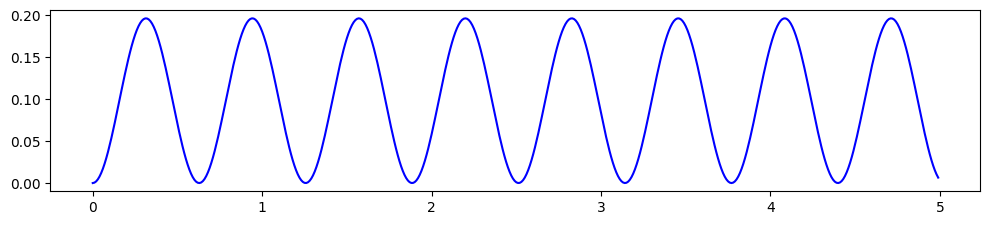

In [6]:
import matplotlib.pyplot as plt

# Comparison plot between solve_ivp and Newmark solutions
plt.figure(figsize=(12, 8))

t = total_time

# Displacement comparison
plt.subplot(3, 1, 1)
plt.plot(time, displacement, label='Newmark Displacement', color='blue')
plt.plot(t, x_analtical, label='solve_ivp Displacement', color='red', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('Displacement (m)')
plt.title('Displacement Comparison')
plt.legend()
plt.grid(True)

# Velocity comparison
plt.subplot(3, 1, 2)
plt.plot(t, velocity, label='Newmark Velocity', color='blue')
plt.plot(t, solve_ivp_velocity, label='solve_ivp Velocity', color='red', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.title('Velocity Comparison')
plt.legend()
plt.grid(True)

# Acceleration comparison
plt.subplot(3, 1, 3)
plt.plot(t, a_analytical, label='Newmark Acceleration', color='blue')
plt.plot(t, np.gradient(solve_ivp_velocity, t), label='solve_ivp Acceleration', color='red', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s²)')
plt.title('Acceleration Comparison')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

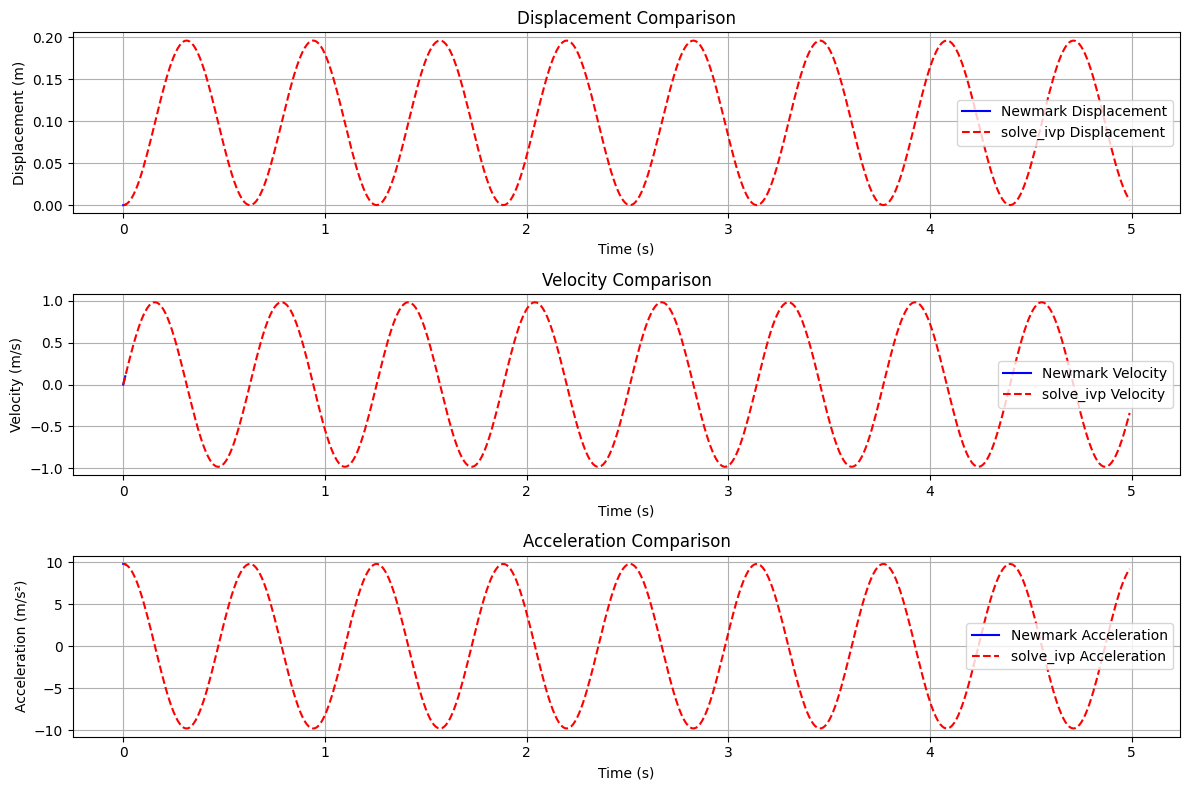

In [ ]:
import matplotlib.pyplot as plt

# Extract Newmark solution
newmark_time = case_results[0]['time']
newmark_displacement = case_results[0]['displacement'].flatten()
newmark_velocity = case_results[0]['velocity'].flatten()
newmark_acceleration = case_results[0]['acceleration'].flatten()

# Extract solve_ivp solution
solve_ivp_time = time
solve_ivp_displacement = displacement_ivp #.flatten()
solve_ivp_velocity = velocity_ivp #.flatten()
solve_ivp_acceleration = acceleration_ivp #np.gradient(solve_ivp_velocity, dt)  # Compute acceleration from velocity

# Plot displacement comparison
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(newmark_time, newmark_displacement, label='Newmark Displacement', color='blue')
plt.plot(solve_ivp_time, solve_ivp_displacement, label='solve_ivp Displacement', color='red', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('Displacement (m)')
plt.title('Displacement Comparison')
plt.legend()
plt.grid(True)

# Plot velocity comparison
plt.subplot(3, 1, 2)
plt.plot(newmark_time, newmark_velocity, label='Newmark Velocity', color='blue')
plt.plot(solve_ivp_time, solve_ivp_velocity, label='solve_ivp Velocity', color='red', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.title('Velocity Comparison')
plt.legend()
plt.grid(True)

# Plot acceleration comparison
plt.subplot(3, 1, 3)
plt.plot(newmark_time, newmark_acceleration, label='Newmark Acceleration', color='blue')
plt.plot(solve_ivp_time, solve_ivp_acceleration, label='solve_ivp Acceleration', color='red', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s²)')
plt.title('Acceleration Comparison')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()